## Initialize Notebook

CAPM
Import data from: D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\SampleData\Sample\LongTerm-DataPreparation_Skew.csv
Original CAPM is being used as Target
Nr of rows:
72538


<Figure size 640x480 with 0 Axes>

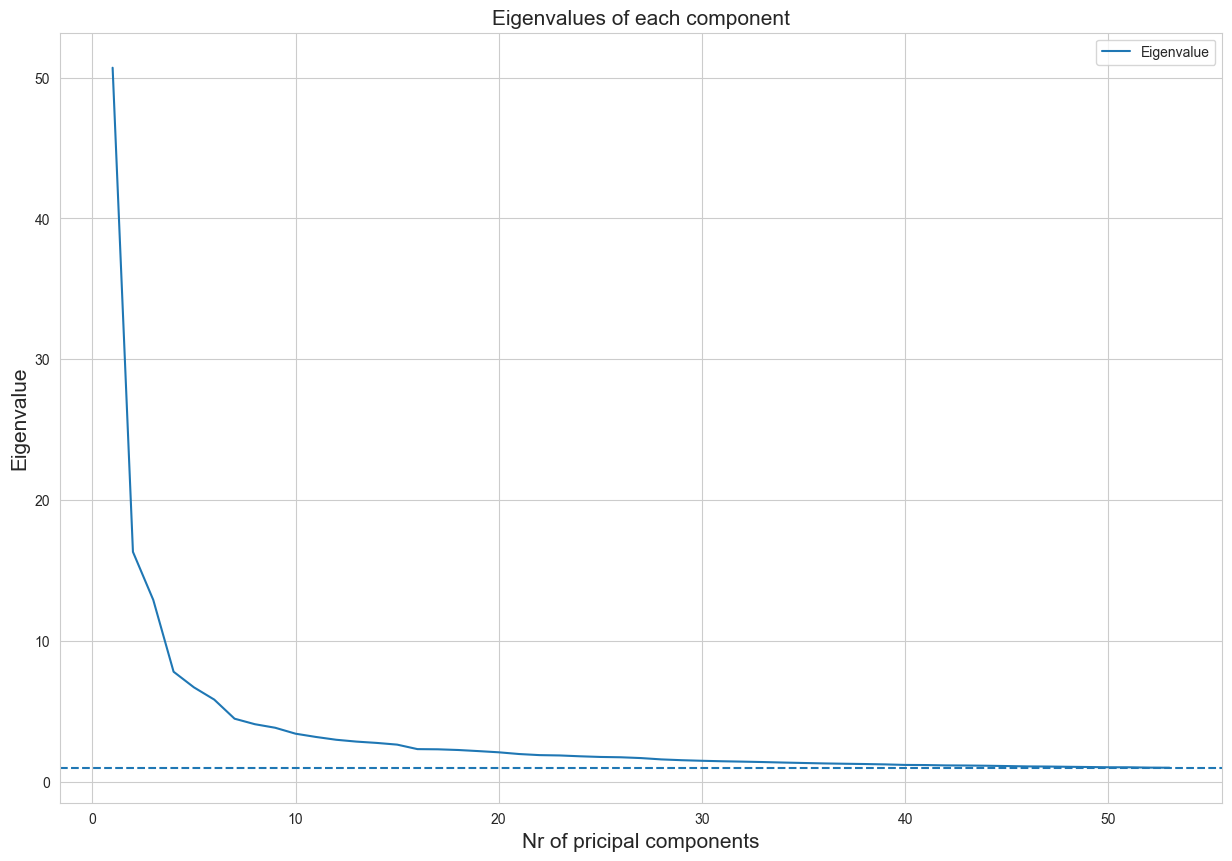

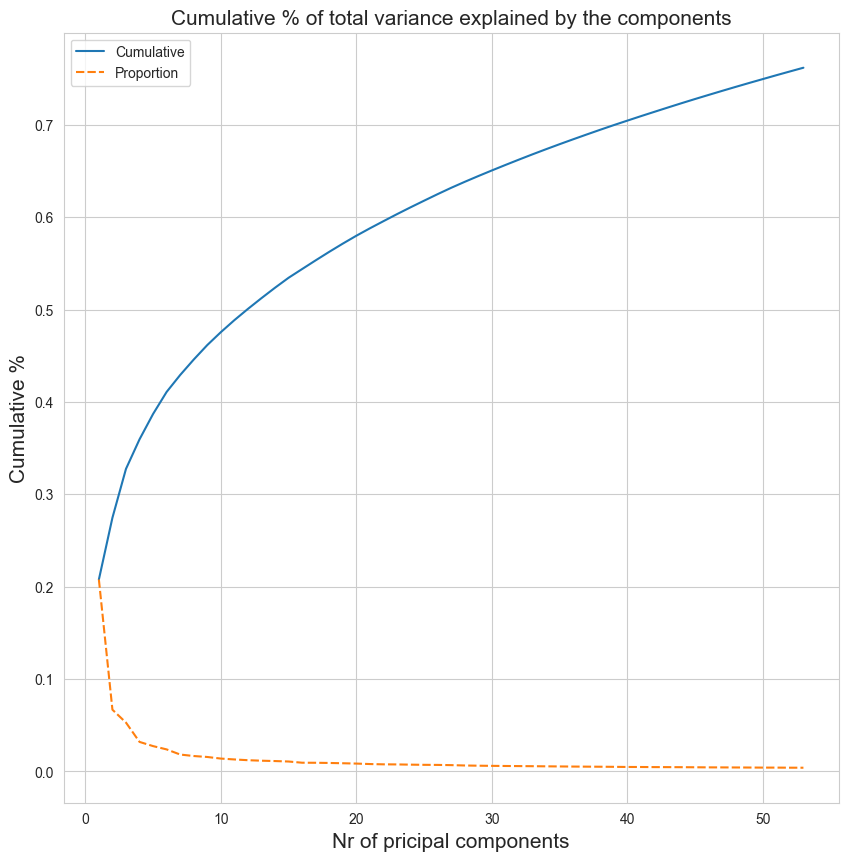

The variance explained by each component is: [50.70262543 16.3180414  12.90616231  7.80559243  6.69692605  5.82614766
  4.47015907  4.07836541  3.82626867  3.40508117  3.17395217  2.97398597
  2.84255924  2.7491931   2.6284572   2.30920491  2.29580116  2.24676716
  2.1685526   2.08344875  1.96058327  1.88331954  1.85945512  1.79999003
  1.75303096  1.72999438  1.67342676  1.57892838  1.52235707  1.48115797
  1.44613583  1.42029951  1.39091026  1.35520895  1.32448072  1.29342424
  1.27059382  1.25051426  1.2247642   1.18608517  1.17810508  1.15156743
  1.14454538  1.12935887  1.10669478  1.0815426   1.07222534  1.05458183
  1.03848544  1.01988948  1.01877496  0.99533768  0.98807987]
The total variance explained by the components is: 0.7618344466001962


In [6]:
import sys
#define path to get paths
pathsPath = r'D:\Code\RD\Paths'

if pathsPath not in sys.path:
    sys.path.insert(1, pathsPath)

#import paths
import definePaths as pathsMain

#set paths
fmpPath = pathsMain.get_FMPapi_path()
functions_path = pathsMain.get_insertMlFunctions_path()

#create a list of paths
pathList = [fmpPath, functions_path]
#set personal code paths
for index, path in enumerate(pathList):
    id_ = index +1
    sys.path.insert(id_, path)

sys.path.insert(10, r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM')

import Visualizations_Functions as viz 
import Classification_CV as class_cv
import DataPreparation as preprocess 
import FeatureExtraction as ft_extract 
import DataScalling as scalling
import FeatureSelection as ft_selection
import importCleanedData as importData
import importSubsets as subsets

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from tensorflow import keras

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

#set preferences
sns.set_style('whitegrid')


#set color for graphs
palette = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

dir = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\SampleData\Sample'
df_model_skew,df_target = importData.importCleanedData(dir=dir,target='CAPM')


#split data
date = '2018-01-01'
#split data without transformation
x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test = importData.splitData(df_model_skew, date) 


#set columns
ratio_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Ratio'))]
shares_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Share'))]
margin_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Margin'))]
turnover_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Turnover'))]
dividend_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('dividend'))]



tran_component, test_components = importData.runPCA(x_train_out= x_train_out,x_test = x_test)



def import_folderData_csv_file (path):
    import os
    import glob
    import time 
    import pandas as pd 
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.DataFrame()
    for file in csv_files:
        df_temp = pd.read_csv(file)
        df_temp['file'] = file
        df = pd.concat([df, df_temp], axis=0)
        
        
    return(df)


#Target 0 
#import validation data 
target_0_val_path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_0\Validation\Full_Validation'
target_0_val = import_folderData_csv_file(target_0_val_path)


target_0_test_path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_0\Test'
target_0_test = import_folderData_csv_file(target_0_test_path)
target_0_test.loc[target_0_test['model']=='Keras_NN','model'] = 'NeuralNetwork'


#Target 15
target_15_val_path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_15\Validation\Full_Validation'
target_15_val = import_folderData_csv_file(target_15_val_path)
target_15_val = target_15_val.loc[((target_15_val['model']=='Keras_NN') & (target_15_val['subset']=='PCA'))==False]

target_15_val = target_15_val.loc[target_15_val.model!='MLP-Oversampling']
target_15_val = target_15_val.loc[target_15_val.subset!='Lasso - Outliers']
target_15_val.loc[target_15_val['model']=='Keras_NN','model'] = 'NeuralNetwork'


target_15_test_path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_15\Test'
target_15_test = import_folderData_csv_file(target_15_test_path)
target_15_test.loc[target_15_test['model']=='Keras_NN','model'] = 'NeuralNetwork'

#import subsets
lasso_subset_0, lasso_ubset_15, mi_subset_0, mi_subset_15, lgb_subset, corr_subset0, corr_subset15 = subsets.importSubsets()

#set color list
color_list= [palette[0],palette[3],palette[1]]

### Functions

In [88]:
def importModels_Target_0 ():
    print('Importing models from Target 0')
    import joblib
    model_list = []
    model_names = ['LogisticRegression.pkl','NeuralNetwork.pkl','LightGB.pkl','NeuralNetwork_PCA.pkl']
    path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_0\Models\Final Models\\'
    for  model_name in model_names:
        model_clone = joblib.load(f'{path}{model_name}')
        
        model_list.append(model_clone)
        
        
    lgb_outliers_path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_0\Models\Final Models\\'
    scaler = joblib.load(f'{path}scaler.pkl')

    model_names = ['LogisticRegression','NeuralNetwork','LightGB','NeuralNetwork_PCA']
    
    
    return(model_names, model_list, scaler)

def importRawModels_Target_0 ():
    
    print('Importing models from Target 0 - Traned with outliers')
    import joblib
    model_list = []
    model_names = ['LightGB_Raw.pkl',]
    path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_0\Models\Raw\Lasso\\'
    for  model_name in model_names:
        model_clone = joblib.load(f'{path}{model_name}')
        
        model_list.append(model_clone)
        
        
    scaler = joblib.load(f'{path}scaler.pkl')

    model_names = ['LightGB_Raw',]
    
    
    return(model_names, model_list, scaler)




def predict_Target_0 (model, x_test):
    prediction = model.predict(x_test)
    proba = model.predict_proba(x_test)[:,1]
    
    return(prediction, proba)

def cal_SharpeRatio(precision,n):
    upper = (2*precision - 1) 
    lower = 2 * np.sqrt(precision * (1 - precision))
    sharpe_ratio = upper/lower * np.sqrt(n)
    return sharpe_ratio

def calcMetrics (y_true,prediction):
    from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
    accuracy = accuracy_score(y_true,prediction)
    precision = precision_score(y_true,prediction)
    auc = roc_auc_score(y_true,prediction)
    return(accuracy,precision,auc)


def calc_AvgAlpha (model_name,assess_test):
    pos_ = assess_test.loc[assess_test[f'{model_name}_prediction']==1]
    avg_alpha = pos_['futAlpha'].mean()
    avg_std = pos_['futAlpha'].std()
    return(avg_alpha,avg_std)


def calc_Avgreturns (model_name,assess_test):
    pos_ = assess_test.loc[assess_test[f'{model_name}_prediction']==1]
    returns = pos_['stockQuarterlyReturns'].mean()
    return(returns)


def formatTestPredictions(assess_df):
    
    assess_df.reset_index(inplace=True)
    assess_df['subset'] = 'Lasso'
    assess_df.loc[assess_df['model']=='LightGB_Raw','subset'] = 'Lasso - Outliers'
    assess_df.loc[assess_df['model']=='NeuralNetwork_PCA','subset'] = 'PCA'
    assess_df.loc[assess_df['model']=='NeuralNetwork_PCA','model'] = 'NeuralNetwork'
    assess_df.loc[assess_df['model']=='LightGB_Raw','model'] = 'LightGB'
    
    return(assess_df)


def calcRandomValidation_score ():
    val_predictions = pd.read_csv(r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_0\Models\Final Models\ValidationPredictions\crossValidation_Preictions.csv')
    val_predictions = val_predictions.loc[val_predictions['model'] == 'LogisticRegression',:]

    val_predictions['Random'] = True
    accuracy,precision,auc = calcMetrics(val_predictions['Target'], val_predictions['Random'])
    return (accuracy,precision,auc)
    
    
def fillRandom_Val (assess_df):
    accuracy,precision,auc = calcRandomValidation_score()
    col_list = ['AUC_val', 'Accuracy_val', 'Precision_val']
    metric_list = [auc,accuracy,precision]
    for col, value in zip(col_list, metric_list):
        assess_df.loc[assess_df['model'] =='Random',col] = value
        
    return(assess_df)

def assessModelPerformance_Target0 (x_train, y_true, df_target,model_list, model_names, n=1000):
    #set variables
    x_test_stand = x_train
    y_true = y_true
    n = n
    
    #assure that all date variables are in string format
    df_target['fillingDate'] = (df_target['fillingDate']).astype(str)
    df_target['date'] = (df_target['date']).astype(str)

    
    #create df to store predictions of each model in the test set -  set index as test index
    assess_test = pd.DataFrame(index = y_test.index)
    #store ground truth in df
    assess_test['Target'] = y_true
    #create random strategy 
    assess_test['Random'] = 1

    #merge with target df 
    # assess_test = pd.merge(assess_test.reset_index(),
    #                     df_target.drop(columns=  ['excessRet', 'newAlpha','excessReturns']),
    #                     on = ['symbol','date','fillingDate'],
    #                     how='left')
    assess_test = pd.merge(assess_test.reset_index(),
                        df_target,
                        on = ['symbol','date','fillingDate'],
                        how='left')
    
    #create list to store results
    assess_list = []
    #for each model in the list
    for model,model_name in zip(model_list,model_names):
        #set ground truth
        y_true = y_test_dict['Target_0']
        #make predictions
        if model_name != 'NeuralNetwork_PCA':
            print(model_name)
            prediction, proba = predict_Target_0(model, x_test_stand)
            
        if model_name == 'NeuralNetwork_PCA':
            prediction, proba = predict_Target_0(model, test_components)
            
        #store predictions in df
        assess_test[f'{model_name}_prediction'] = prediction
        assess_test[f'{model_name}_proba'] = proba
        
        #calculate metrics
        accuracy,precision,auc = calcMetrics(y_true,prediction)
        sharpe_ratio = cal_SharpeRatio(precision,n)
        alpha,avg_std = calc_AvgAlpha(model_name,assess_test=assess_test)

        #store metrics in dict
        assess_dict = {}
        assess_dict['model'] = model_name
        assess_dict['auc'] = auc
        assess_dict['accuracy'] = accuracy
        assess_dict['precision'] = precision
        assess_dict['sharpeRatio'] = sharpe_ratio
        assess_dict['alpha'] = alpha
        
        #for each n in the list
        for n_ in [n]: 
            #sort df by model proba and select top n 
            top_precision = assess_test.sort_values(by = f'{model_name}_proba', ascending=False).iloc[:n_]
            
            #set ground truth and prediction
            y_true = top_precision['Target']
            prediction = top_precision[f'{model_name}_prediction']
            
            #calculate metrics
            accuracy,precision,auc = calcMetrics(y_true,prediction)
            sharpe_ratio = cal_SharpeRatio(precision,n)
            alpha,avg_std = calc_AvgAlpha(model_name,top_precision)
            
            #store metrics in dict
            assess_dict[f'precision_Top{n_}'] = precision
            assess_dict[f'sharpeRatio_Top{n_}'] = sharpe_ratio 
            assess_dict[f'alpha_Top{n_}'] = alpha 
        #append dict to list
        assess_list.append(assess_dict)
        
    #predict benchmark strategy - invest in all assets
    randomDict = dict()
    y_true = y_test_dict['Target_0']
    #calc metrics for random strategy
    accuracy,precision,auc = calcMetrics(y_true,assess_test['Random'])
    sharpe_ratio = cal_SharpeRatio(precision,n)

    #calc vg alpha of all assets
    alpha= assess_test['futAlpha'].mean()
    
    #set values in dict
    randomDict['model'] = 'Random'
    randomDict['auc'] = auc
    randomDict['accuracy'] = accuracy
    randomDict['precision'] = precision
    randomDict['sharpeRatio'] = sharpe_ratio
    randomDict['alpha'] = alpha
    randomDict[f'precision_Top{n_}'] = 0
    randomDict[f'sharpeRatio_Top{n_}'] = 0 
    randomDict[f'alpha_Top{n_}'] = 0 
    #append to list
    assess_list.append(randomDict)
    assess_df = pd.DataFrame(assess_list).set_index('model')

    assess_df.columns
    
    #set columns of interest
    cols_ = ['auc', 'accuracy', 'precision']
    #for each column
    for col in cols_:
        #rename columns
        new_name = col + '_test'
        assess_df.rename(columns = {col:new_name},inplace=True)
        
    #get validation scores
    valScores = to_show_df['Validation']
    #for each column
    for col in valScores.columns:
        #rename columns
        new_name = col + '_val'
        valScores.rename(columns = {col:new_name},inplace=True)
         
    #format test predictions
    assess_df = formatTestPredictions(assess_df)
    valScores = valScores.reset_index()

    #merge test and validation scores
    assess_df = pd.merge(valScores, assess_df, on = ['model','subset'], how='outer')
    assess_df = fillRandom_Val(assess_df)
        
        
    assess_df = assess_df.dropna()
    display(assess_df)
    return(assess_df,assess_test)

In [89]:
def predict_Target_15 (model, x_test):
    prediction = model.predict(x_test)
    proba = model.predict_proba(x_test)[:,1]
    
    return(prediction, proba)

def cal_SharpeRatio(precision,n):
    upper = (2*precision - 1) 
    lower = 2 * np.sqrt(precision * (1 - precision))
    sharpe_ratio = upper/lower * np.sqrt(n)
    return sharpe_ratio

def calcMetrics (y_true,prediction):
    from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
    accuracy = accuracy_score(y_true,prediction)
    precision = precision_score(y_true,prediction)
    auc = roc_auc_score(y_true,prediction)
    return(accuracy,precision,auc)


def calc_AvgAlpha (model_name,assess_test):
    pos_ = assess_test.loc[assess_test[f'{model_name}_prediction']==1]
    avg_alpha = pos_['futAlpha'].mean()
    avg_std = pos_['futAlpha'].std()
    return(avg_alpha,avg_std)


def scale_MI (x_test, scaler):
    
    order_cols = ['Volatility_84', 'Volatility_21', 'operatingIncome',
       'costAndExpenses_TTM', 'dividendPayoutRatio', 'totalDividend',
       'dividend', 'netIncome_TTM', 'dividendsPaid',
       'otherCurrentLiabilities', 'dividendYield', 'totalAssets',
       'eps_TTM', 'otherNonCurrentAssets',
       'totalLiabilitiesAndTotalEquity', 'otherCurrentAssets',
       'marketcap_bin', 'netCashUsedForInvestingActivites', 'goodwill',
       'totalNonCurrentAssets', 'netIncome_bin']
    ft_scale = scaler.feature_names_in_
    
    rest_cols = [col for col in x_test.columns if col not in ft_scale]
    
    x_test_stand = pd.DataFrame(scaler.transform(x_test[ft_scale]),
                                index = x_test.index, 
                                columns = ft_scale)
    x_test_stand = pd.concat([x_test_stand,x_test[rest_cols]], axis=1)
    x_test_stand = x_test_stand[order_cols]
    return(x_test_stand)


def sharpe_Precision (model_name, assess_test):
    from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
    temp_df = assess_test.loc[assess_test[f'{model_name}_prediction']==True]

    temp_df.loc[temp_df['futAlpha']>=0,'newTarget'] = 1
    temp_df['newTarget'] = temp_df['newTarget'].fillna(0)
    
    y_true = temp_df['newTarget']
    prediction = temp_df[f'{model_name}_prediction']
    
    precision = precision_score(y_true,prediction)
    
    return(precision)


def formatAssessDf (assess_df):
    assess_df = assess_df.reset_index()
    assess_df['subset'] = 'MI'
    assess_df.loc[assess_df['model'].str.contains('PCA'),'subset'] = 'PCA'

    new_model_names = []

    for name in assess_df.model:
        new_name = name.split('_')[0]
        new_model_names.append(new_name)
    assess_df['model'] = new_model_names

    return(assess_df)

def calcRandomValidation_score_15 ():
    
    val_predictions = pd.read_csv(r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_15\Models\Final Models\ValidationPredictions\crossValiidationPredictions.csv')

    val_predictions = val_predictions.loc[val_predictions['model'] == 'LightGB',:]
    
    val_predictions['Random'] = True
    accuracy,precision,auc = calcMetrics(val_predictions['Target'], val_predictions['Random'])
    return (accuracy,precision,auc)
    

def fillRandom_Val_15 (assess_df):
    accuracy,precision,auc = calcRandomValidation_score_15()
    recall = 1
    col_list = ['AUC_val', 'Accuracy_val', 'Precision_val', 'recall_val']
    metric_list = [auc,accuracy,precision,recall]
    for col, value in zip(col_list, metric_list):
        assess_df.loc[assess_df['model'] =='Random',col] = value
        
    return(assess_df)


def assessModelPerformance_Target_15 ( x_train, y_true, df_target,model_list, model_names, n=100):
    from sklearn.metrics import recall_score
    x_test_stand = x_train
    y_true = y_true

    df_target['fillingDate'] = (df_target['fillingDate']).astype(str)
    df_target['date'] = (df_target['date']).astype(str)

    n = n
    assess_list = []
    assess_test = pd.DataFrame(index = y_test.index)
    assess_test['Target'] = y_true
    assess_test['Random'] = 1

    assess_test = pd.merge(assess_test.reset_index(),
                        df_target.drop(columns=  ['excessRet', 'newAlpha','excessReturns']),
                        on = ['symbol','date','fillingDate'],
                        how='left')



    for model,model_name in zip(model_list,model_names):
        y_true = y_test_dict['Target_0.15']
        if (model_name != 'NeuralNetwork_PCA') & (model_name != 'LogisticRegression_PCA'):
            print(model_name)
            prediction, proba = predict_Target_15(model, x_test_stand)
            
            
        if (model_name == 'NeuralNetwork_PCA') | (model_name == 'LogisticRegression_PCA'):
            print(model_name)
            print(test_components.shape)
            prediction, proba = predict_Target_15(model, test_components)
            

        assess_test[f'{model_name}_prediction'] = prediction
        assess_test[f'{model_name}_proba'] = proba
        
        accuracy,precision,auc = calcMetrics(y_true,prediction)
        recall = recall_score(y_true,prediction)
        
        prec_sharpe = sharpe_Precision(model_name, assess_test)
        sharpe_ratio = cal_SharpeRatio(prec_sharpe,n)
        alpha,avg_std = calc_AvgAlpha(model_name,
                                    assess_test=assess_test)

        assess_dict = {}
        assess_dict['model'] = model_name
        assess_dict['auc'] = auc
        assess_dict['accuracy'] = accuracy
        assess_dict['precision'] = precision
        assess_dict['recall'] = recall
        assess_dict['alpha'] = alpha
        
        for n_ in [1000]:
                
            top_precision = assess_test.sort_values(by = f'{model_name}_proba', ascending=False).iloc[:n_]
            
            y_true = top_precision['Target']
            prediction = top_precision[f'{model_name}_prediction']
            
            accuracy,precision,auc = calcMetrics(y_true,prediction)
            sharpe_ratio = cal_SharpeRatio(precision,n)
            alpha,avg_std = calc_AvgAlpha(model_name,top_precision)
            
            assess_dict[f'precision_Top{n_}'] = precision
            # assess_dict[f'sharpeRatio_Top{n_}'] = sharpe_ratio 
            assess_dict[f'alpha_Top{n_}'] = alpha 
        assess_list.append(assess_dict)

    randomDict = dict()
    y_true = y_test_dict['Target_0.15']

    accuracy,precision,auc = calcMetrics(y_true,assess_test['Random'])
    sharpe_ratio = cal_SharpeRatio(precision,n)

    alpha= assess_test['futAlpha'].mean()
    alphaSTD= assess_test['futAlpha'].std()
    randomDict['model'] = 'Random'
    randomDict['auc'] = auc
    randomDict['accuracy'] = accuracy
    randomDict['precision'] = precision
    randomDict['recall'] = 1
    # randomDict['sharpeRatio'] = sharpe_ratio
    randomDict['alpha'] = alpha

    assess_list.append(randomDict)
    assess_df = pd.DataFrame(assess_list).set_index('model').fillna(0)

    cols_ = ['auc', 'accuracy', 'precision','recall','alpha']

    for col in cols_:
        new_name = col + '_test'
        assess_df.rename(columns = {col:new_name},inplace=True)
        
        
    valScores = to_show_df['Validation']
    for col in valScores.columns:
        new_name = col + '_val'
        valScores.rename(columns = {col:new_name},inplace=True)
        
        
    assess_df = formatAssessDf(assess_df)
    valScores = valScores.reset_index()


    assess_df = pd.merge(valScores,
                         assess_df,
                         on = ['model','subset'],
                         how='outer')
    assess_df = fillRandom_Val_15(assess_df)
    assess_df = assess_df.drop(columns = ['Accuracy_val','accuracy_test'])

    for col in assess_df:
        new_name = col.lower()
        assess_df.rename(columns = {col:new_name},inplace=True)
    
    assess_df = assess_df.drop_duplicates()
    
    display(assess_df)
    return(assess_df,assess_test)


def calc_classicSharpe (alpha, value,):
    print(' ')
    print(f'Calculating quarterly Sharpe')
    print(f'Calculating Sharpe with rfr of {value*100}%')
    print(' ')
    alpha_ = alpha.copy()
    sharpeRatio =((alpha_.mean() - value)  / alpha_.std()).fillna(0).values
    return(sharpeRatio)

def annualizeMetric (data,col_name):
    data[col_name] = data[col_name] * 4
    
def annualizeRatios (data,col_name):
    data[col_name] = data[col_name] * np.sqrt(4)
    


def calc_AnnualizedMetrics (timeAssess_df, returns, value,sortino_thresh = 0):
    
    quarterly_rfr = value / 4
    df_sharpe = pd.DataFrame(index = timeAssess_df.index)
    
    print(f'Ratios are being calculated with a annualized risk-free rate return of {value*100}%')
    print(f'Quarterly risk-free rate return is {quarterly_rfr*100}%')
    print(f'Negative volatility is being calculated with a threshold of {sortino_thresh*100}%')
    
    
    sharpe_ = list((returns.mean() - value) / returns.std())
    returns_ = list(returns.mean().values * 4)
    volatility = (returns.std() * np.sqrt(4)).values
    
    neg_vol = []
    for col in returns.columns:
        negVol = returns.loc[:, col]
        tdd = []
        # negVol = returns.loc[returns[col] < sortino_thresh, col]
        for values in negVol:
            if values < sortino_thresh:
                newValue = values - sortino_thresh
                tdd.append(newValue)
            else:
                tdd.append(0)
        negVol = np.std(tdd) * np.sqrt(4)
        # negVol = negVol.std() * np.sqrt(4)
        neg_vol.append(negVol)
    
    df_sharpe['quarterlydReturns'] =returns.mean().values
    df_sharpe['annualizedReturns'] =returns_
    df_sharpe['quarterlyVolatility'] = returns.std().values
    df_sharpe['annualizedVolatility'] = volatility
    df_sharpe['negativeAnnualizedVolatility'] = neg_vol
    df_sharpe['sharpeRatio'] = (df_sharpe['quarterlydReturns']- (quarterly_rfr)) / df_sharpe['quarterlyVolatility']
    df_sharpe['annualizedSharpeRatio'] = (df_sharpe['annualizedReturns']- value) / df_sharpe['annualizedVolatility']
    df_sharpe['annualizedSortinoRatio'] = (df_sharpe['annualizedReturns']-value) / df_sharpe['negativeAnnualizedVolatility']
    return(df_sharpe)

def performTimeAnalysis (assess_test, model_list,model_names,models_,value = 0):
    
    
    print(f'Performing time analysis')
    print(f'Annual Risk-free rate of {value*100}%')
    quarterlyValue = value/4
    print(f'Quarterly Risk-free rate of {quarterlyValue*100}%')
    from sklearn.metrics import recall_score   
    quarter_list = assess_test.reset_index()['quarter'].unique()
    year_list= assess_test.reset_index()['year'].unique()
    
    timeAssess_list = []
    
    #for each period 
    for year in year_list:
        for quarter in quarter_list:
            
            #set qury to filter dataset
            quarter_query = assess_test.loc[(assess_test['quarter']==quarter)&(assess_test['year']==year)]
            #filter dataset
            df_temp = assess_test.loc[quarter_query.index]
            avg_alpha = df_temp['futAlpha'].mean()
    
            timeAssess_dict = {}
            timeAssess_dict['year'] = year
            timeAssess_dict['quarter'] = quarter
            if len(df_temp)>0:
                
                #for each model 
                for model,model_name in zip(model_list,model_names):
                    #set Ground Truth 
                    y_true = df_temp['Target']
                    
                    #get predictions 
                    prediction = df_temp[f'{model_name}_prediction']
                    
                    #calculate ML performance metrica 
                    accuracy,precision,auc = calcMetrics(y_true,prediction)
                    recall = recall_score(y_true,prediction)
                    sharpe_ratio = cal_SharpeRatio(precision,n)
                    alpha,avg_std = calc_AvgAlpha(model_name,df_temp)
                    stockReturns = calc_Avgreturns(model_name,df_temp)
                    
                    #add performance metrics to dict 
                    timeAssess_dict[f'{model_name}_accuracy'] = accuracy
                    timeAssess_dict[f'{model_name}_precision'] = precision
                    timeAssess_dict[f'{model_name}_recall'] = recall
                    timeAssess_dict[f'{model_name}_alpha'] = alpha
                    timeAssess_dict[f'{model_name}_returns'] = stockReturns
                    timeAssess_dict[f'{model_name}_sharpeRatio'] = sharpe_ratio
                    timeAssess_dict[f'{model_name}_auc'] = auc
                    
                    #for each N
                    for n_ in [25,50]:
                        
                        #sort observations based on probability and filter top N
                        top_precision = df_temp.sort_values(by = f'{model_name}_proba', ascending=False).iloc[:n_]
                        #set ground truth and predictions 
                        y_true = top_precision['Target']
                        prediction = top_precision[f'{model_name}_prediction']
                        
                        #calculate metrics for top N for each quarter 
                        accuracy,precision,auc = calcMetrics(y_true,prediction)
                        sharpe_ratio = cal_SharpeRatio(precision,n)
                        
                        #calculate avg alpha and quarterly returns 
                        alpha,avg_std = calc_AvgAlpha(model_name,top_precision)
                        stockReturns = calc_Avgreturns(model_name,top_precision)
                        
                        #store metrics 
                        timeAssess_dict[f'{model_name}_accuracy_Top{n_}'] = accuracy
                        timeAssess_dict[f'{model_name}_precision_Top{n_}'] = precision
                        timeAssess_dict[f'{model_name}_sharpeRatio_Top{n_}'] = sharpe_ratio
                        timeAssess_dict[f'{model_name}_returns_Top{n_}'] = stockReturns
                        timeAssess_dict[f'{model_name}_alpha_Top{n_}'] = alpha
                
                #calculate metrics for the random "BenchMark" that classifies all observations as outperformers
                model_name = 'Random'
                y_true = df_temp['Target']
                prediction = df_temp[f'Random']
                alpha = df_temp['futAlpha'].mean()
                avgReturns = (df_temp['stockQuarterlyReturns']).mean()
                
                accuracy,precision,auc = calcMetrics(y_true,prediction)
                recall = 1
                sharpe_ratio = cal_SharpeRatio(precision,n)
                
                
                timeAssess_dict[f'{model_name}_auc'] = auc
                timeAssess_dict[f'{model_name}_accuracy'] = accuracy
                timeAssess_dict[f'{model_name}_precision'] = precision
                timeAssess_dict[f'{model_name}_recall'] = recall
                timeAssess_dict[f'{model_name}_alpha'] = alpha
                timeAssess_dict[f'{model_name}_returns'] = avgReturns
                timeAssess_dict[f'{model_name}_sharpeRatio'] = sharpe_ratio  
                timeAssess_list.append(timeAssess_dict)
            
    timeAssess_df = pd.DataFrame(timeAssess_list).set_index(['year','quarter'])
    timeAssess_df_ = timeAssess_df.copy()

    
    
    accuracies = timeAssess_df.loc[:,timeAssess_df.columns.str.contains('accuracy')]
    precisions = timeAssess_df.loc[:,timeAssess_df.columns.str.contains('precision')]
    recalls = timeAssess_df.loc[:,timeAssess_df.columns.str.contains('recall')]
    aucs = timeAssess_df.loc[:,timeAssess_df.columns.str.contains('auc')]
    
    sharpeRatios = timeAssess_df.loc[:,timeAssess_df.columns.str.contains('sharpeRatio')]
    alphas = timeAssess_df.loc[:,timeAssess_df.columns.str.contains('alpha')]
    returns = timeAssess_df.loc[:,timeAssess_df.columns.str.contains('returns')]

    
    recall = recalls.loc[:,recalls.columns.str.endswith('recall')]
    precision = precisions.loc[:,precisions.columns.str.endswith('precision')]
    accuracy = accuracies.loc[:,accuracies.columns.str.endswith('accuracy')]
    auc = aucs.loc[:,aucs.columns.str.endswith('auc')]
    
    sharpe = sharpeRatios.loc[:,sharpeRatios.columns.str.endswith('sharpeRatio')]
    alpha = alphas.loc[:,alphas.columns.str.endswith('alpha')]
    return_ = returns.loc[:,returns.columns.str.endswith('returns')]

    top50_prec = precisions.loc[:, precisions.columns.str.contains('Top50')]
    top50_alpha = alphas.loc[:,alphas.columns.str.contains('Top50')]
    top50_return = returns.loc[:,returns.columns.str.contains('Top50')]
    top50_sharpe = sharpeRatios.loc[:, sharpeRatios.columns.str.contains('Top50')]
    


    models_ = models_
    #calculate average metrics for each model over all quarters
    avgAuc = auc.mean().values
    avgPrec = precision.mean().values
    avg_acc = accuracy.mean().values
    avg_rec = recall.mean().values
    
    #calculate sharpe ratio using precision
    avgSharpe_ = cal_SharpeRatio(avgPrec,
                                 n)

    #calculate avg alpha for each model 
    avg_alpha = list(alpha.mean().values)
    
    print('Calculate sharpe for portfolio generated by the whole sample')
    #calculate classic sharpe ratio
    sharpe_ = calc_classicSharpe(return_,
                                 quarterlyValue)

    
    #calculate avg returns for each model for top 50 stocks of each quarter
    avgPrec50 = list(top50_prec.mean().values)
    avgPrec50.append(0)
    avg_alpha50 = list(top50_alpha.mean().values)
    avg_alpha50.append(0)
    
    avgSharpe50 = []
    for prec_50_ in avgPrec50:
        if prec_50_ == 0:
            avgSharpe50.append(0)
        else:
            avgSharpe50.append(cal_SharpeRatio(prec_50_,
                                           n))
            
    print('Calculate sharpe for portfolio generated by the top 50 observations of each quarter')
    #calculate classic sharpe ratio for top 50 stocks
    avg_classicSharpe_top50 = list(calc_classicSharpe(top50_return, 
                                                      quarterlyValue))
    avg_classicSharpe_top50.append(0)
                
    #store all metrics in a dataframe       
    timeAssess_df = pd.DataFrame(index= models_)
    timeAssess_df['avg_auc'] = avgAuc
    timeAssess_df['avg_precision'] = avgPrec
    timeAssess_df['avg_accuracy'] = avg_acc
    timeAssess_df['avg_recall'] = avg_rec
    # timeAssess_df['sharpe'] = avgSharpe_
    timeAssess_df['SharpeRatio'] = sharpe_
    timeAssess_df['avg_alpha'] = avg_alpha
    timeAssess_df[f'avg_top50Prec'] = avgPrec50
    # timeAssess_df[f'top50_Sharpe'] = avgSharpe50
    timeAssess_df[f'top50_SharpeRatio'] = avg_classicSharpe_top50
    timeAssess_df[f'avg_top50Alpha'] = avg_alpha50
    
    for col in ['avg_alpha','avg_top50Alpha']:
        annualizeMetric(timeAssess_df,col)
    
    for col in ['SharpeRatio','top50_SharpeRatio']:
        annualizeRatios(timeAssess_df,col)
        
    print(' ')
    return(timeAssess_df,timeAssess_df_)


def quanStats_Ratios (returns,
                      rf = 0.05,
                      periods_per_year = 4 ):
    import quantstats as qs
    
    #set list to store data
    data_list = []
    
    benchMark = returns['Random_returns']
    for col in returns.columns:
        
        split_ = col.split('_')
        if len(split_) == 2:
            model_name = col.split('_')[0]
            
        if (len(split_) == 3) & ('Top50' in col):
            model_name = col.split('_')[0]
            
        if (len(split_) == 4) & ('Top50' in col):
            model_name = col.split('_')[0] + '_' + col.split('_')[1]
        
        if (len(split_) == 3) & (('Top50' in col)==False):
            model_name = col.split('_')[0] + '_' + col.split('_')[1] 
        portfolioReturns = returns[col]
        
        sharpe = qs.stats.sharpe(portfolioReturns,
                                rf=rf,
                                periods=periods_per_year,
                                annualize=True,)
        
        smartSharpe = qs.stats.smart_sharpe(portfolioReturns,
                                rf=rf,
                                periods=periods_per_year,
                                annualize=True,)
        sorttino = qs.stats.sortino(portfolioReturns,
                                rf=rf,
                                periods=periods_per_year,
                                annualize=True,)
        
        smartSortino = qs.stats.smart_sortino(portfolioReturns,
                                                rf=rf,
                                                periods=periods_per_year,
                                                annualize=True,)
        adjustedSortino =  qs.stats.adjusted_sortino(portfolioReturns,
                                                    periods=periods_per_year,
                                                    rf =rf)
        
        annualizedVolatility = qs.stats.volatility(portfolioReturns,
                                                periods=periods_per_year,)
        
        # tdd_ = qs.stats.calc_TDD(portfolioReturns,
        #                          rf=rf,
        #                          periods=4,
        #                          annualize=True,)
        
        ratios_dict = {}
        ratios_dict['model'] = model_name
        ratios_dict['sharpe'] = sharpe
        ratios_dict['smartSharpe'] = smartSharpe
        ratios_dict['sorttino'] = sorttino
        ratios_dict['smartSortino'] = smartSortino
        ratios_dict['adjustedSortino'] = adjustedSortino
        # ratios_dict['TDD'] = tdd_
        
        data_list.append(ratios_dict)
    return(pd.DataFrame(data_list))

### Import Fund Data

In [5]:
def importFundData (ticker_list):
    import sys
    sys.path.insert(1, r'C:\Users\rafae\Personal\Github\GCP-Stock_Market\FMP_API')
    sys.path.insert(2, r'C:\Users\rafae\Personal\Github\GCP-Stock_Market\InsertData')

    import FMP_API as API
    
    date_init = '2018-01-01'

    data_list = []
    for ticker in ticker_list:
        #set key
        key = '54594d7278e0fa3c0831a72c60e04b8d'


        #set stock insert object 
        apiClient = API.getStockData(key,)

        #get data - list of dicts
        companyInfo = apiClient.get_dailyPrices(ticker,
                                                date_init = date_init)


        order_cols = ['symbol','date', 'open', 'high', 'low', 'close', 'adjClose', 'volume',
                        'unadjustedVolume', 'change', 'changePercent', 'vwap','changeOverTime']

        data_list = [*data_list, *companyInfo]

    fundData = pd.DataFrame.from_records(data_list)
    fundData['date'] = pd.to_datetime(fundData['date'])
    
    fundData = fundData.set_index(['symbol','date'])['adjClose'].unstack('symbol')
    fundData_q = fundData.resample('Q').agg('last').pct_change().dropna().iloc[:-1]
    
    return(fundData, fundData_q)

ticker_list = ['SPY','IVV','VOO','QQQ','VGT','BRK-A']
fundData,fundData_q = importFundData(ticker_list)

## Check nr of models per Target

In [6]:
target_0_models = target_0_val.groupby(['model','subset']).count()['precision_train'].shape[0]

target_15_models = target_15_val.groupby(['model','subset']).count()['precision_train'].shape[0]

print('The number of models for target 0 is: ' + str(target_0_models))
print('The number of models for target 15 is: ' + str(target_15_models))

The number of models for target 0 is: 20
The number of models for target 15 is: 20


# Target 0

#### Validation Data

In [8]:
target_0_validation = target_0_val[['model','subset','accuracy_test','precision_test']].groupby(['model','subset']).mean().unstack('model')
target_0_validation

accuracy_test                                         \
model             DecisionTree   LightGB LogisticRegression       MLP   
subset                                                                  
Lasso                 0.526270  0.543447           0.538083  0.536485   
Lasso - Outliers      0.525185  0.543789           0.535286  0.535933   
MI                    0.523093  0.535724           0.529256  0.524387   
PCA                   0.514799  0.537835           0.536066  0.532433   

                               precision_test                               \
model            NeuralNetwork   DecisionTree   LightGB LogisticRegression   
subset                                                                       
Lasso                 0.546433       0.533795  0.546569           0.541866   
Lasso - Outliers      0.544113       0.531332  0.546757           0.537887   
MI                    0.535914       0.531402  0.539966           0.533938   
PCA                   0.548640       0.526109  0.542015           0.542350   

                                          
model                  MLP NeuralNetwork  
subset                                    
Lasso             0.544336      0.558222  
Lasso - Outliers  0.542250      0.557749  
MI                0.530845      0.546378  
PCA               0.542093      0.560931

#### Avg Accuracy and Precision for Target 0 - Validation set

Avg Accuracy


model
DecisionTree          0.522337
LightGB               0.540199
LogisticRegression    0.534673
MLP                   0.532309
NeuralNetwork         0.543775
dtype: float64

Avg Precision


model
DecisionTree          0.530659
LightGB               0.543827
LogisticRegression    0.539010
MLP                   0.539881
NeuralNetwork         0.555820
dtype: float64

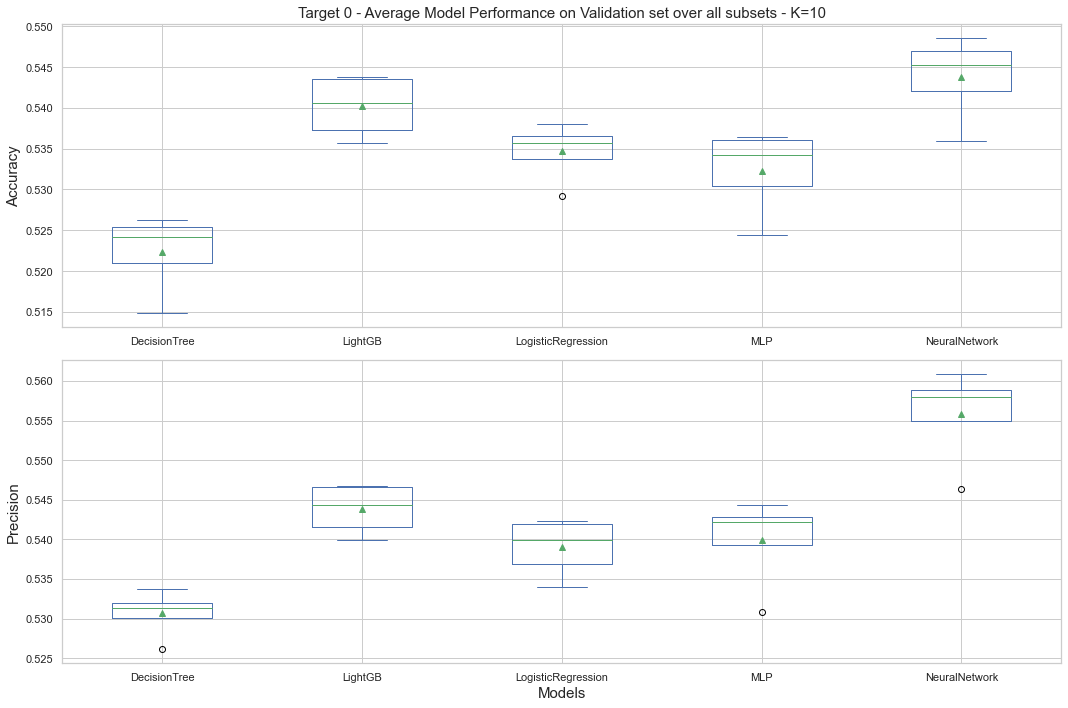

In [6]:
#set copy of dataframe to plot
a = target_0_validation.copy()

#set title
title = 'Target 0 - Average Model Performance on Validation set over all subsets - K=10'

#set figure and size
plt.figure(figsize=(15, 10))

#set 1st subplot
ax1 = plt.subplot(2, 1, 1)
print('Avg Accuracy')
#filter dataframe to plot
df_assess = a['accuracy_test']
#plot boxplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)
display(df_assess.mean())

#set title and labels
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('Accuracy', size=15)

#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
#filter dataframe to plot
df_assess = a['precision_test']
#plot boxplot
df_assess.plot(kind='box', showmeans=True,ax=ax2)
print('Avg Precision')
display(df_assess.mean())
#set title and labels
ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('Precision', size=15)
plt.tight_layout()

#set path to save plot
name_plot = f'{target_0_path}\\{title}.png'
# plt.savefig(name_plot, dpi=300)
#show plot
plt.show()

### Avg subset Performance 

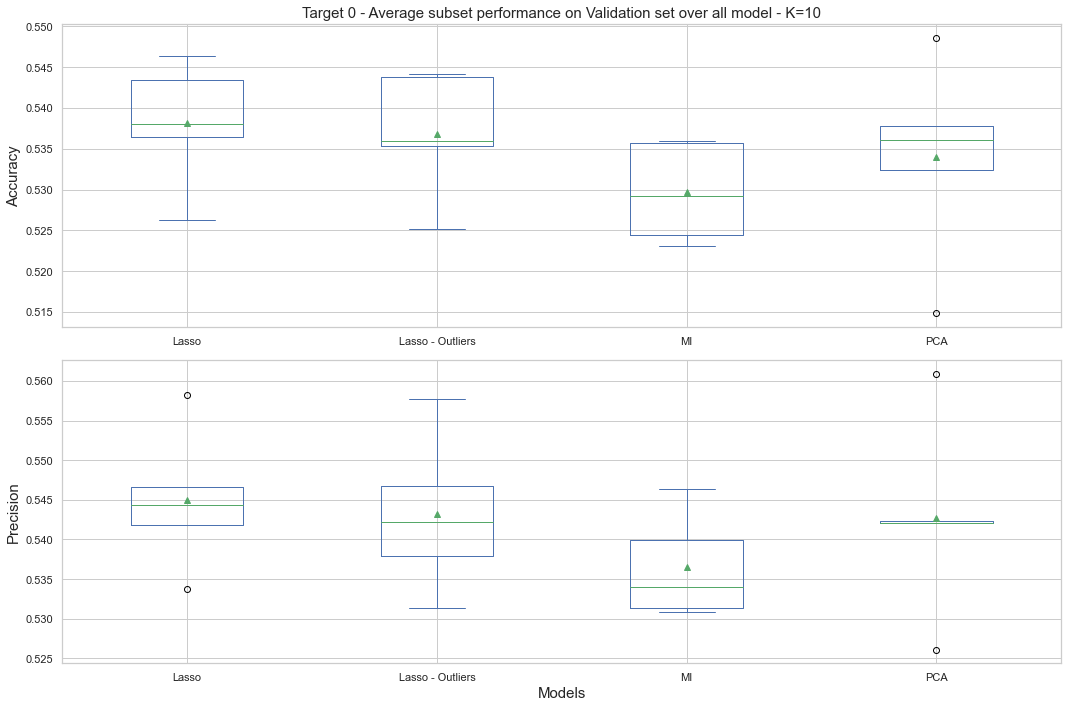

In [7]:
#set copy of dataframe to plot
a = target_0_validation.copy()

#set title
title = 'Target 0 - Average subset performance on Validation set over all model - K=10'

#set figure and size
plt.figure(figsize=(15, 10))

#set 1st subplot
ax1 = plt.subplot(2, 1, 1)

#filter dataframe to plot
df_assess = a['accuracy_test'].T
#plot boxplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('Accuracy', size=15)

#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
#filter dataframe to plot
df_assess = a['precision_test'].T
#plot boxplot
df_assess.plot(kind='box', showmeans=True,ax=ax2)
#set title and labels
ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('Precision', size=15)
plt.tight_layout()
#set path to save plot

name_plot = f'{target_0_path}\\{title}.png'
# plt.savefig(name_plot, dpi=300)
#show plot
plt.show()

### Top Models

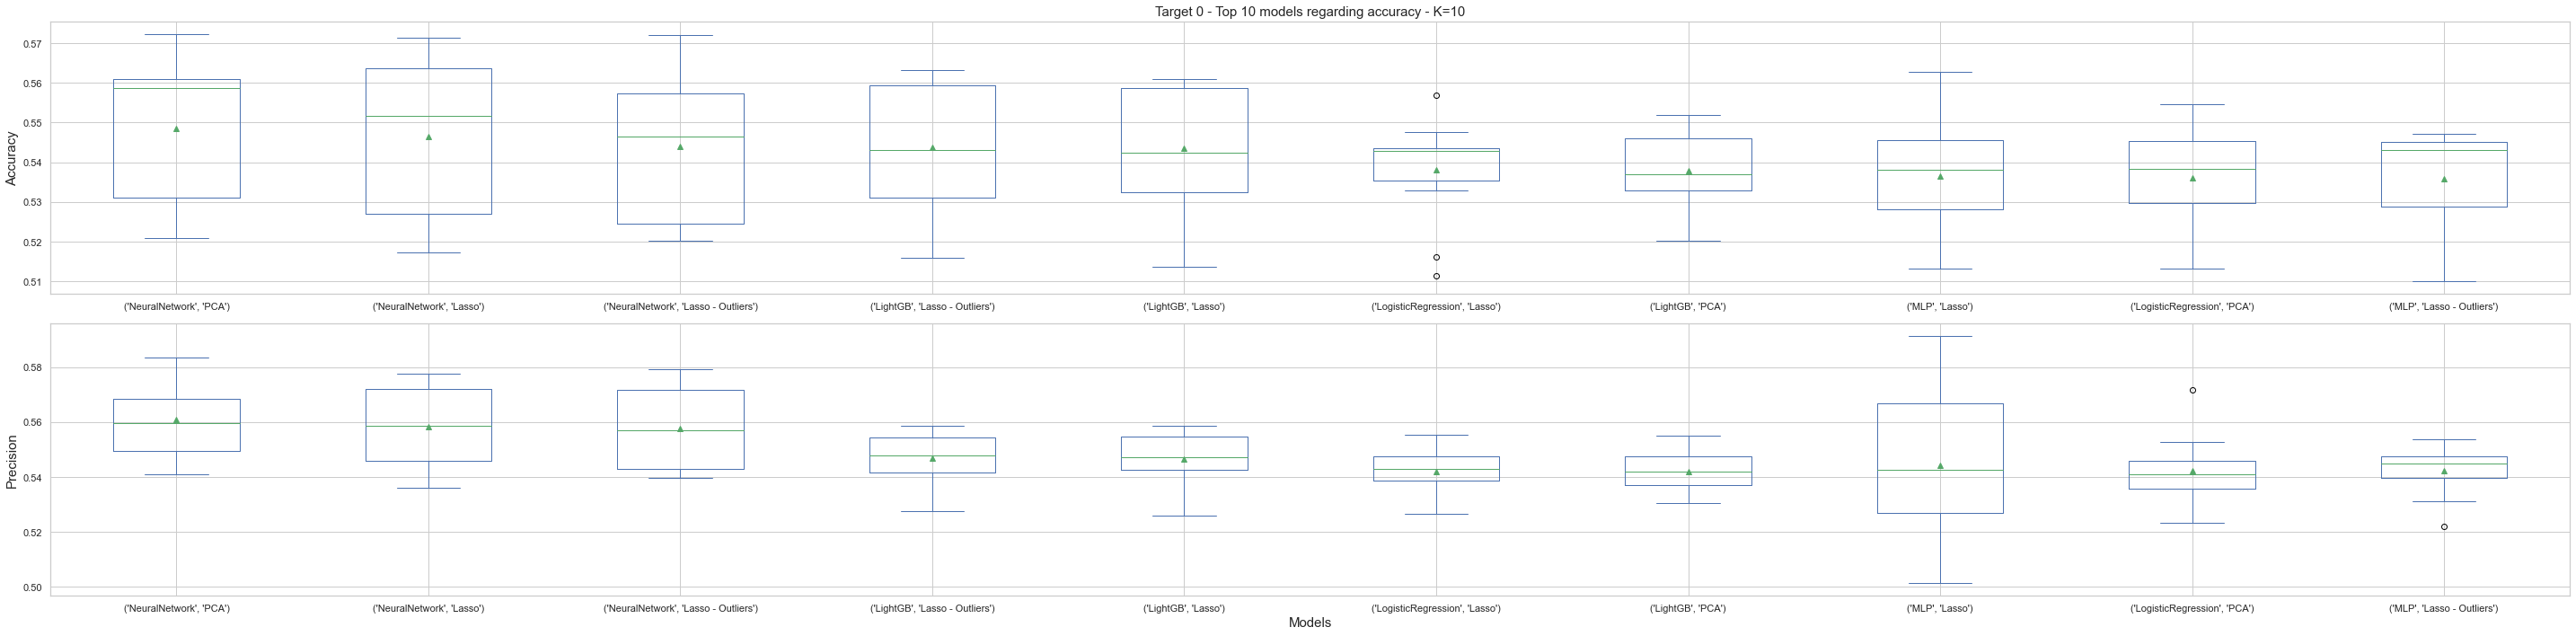

In [5]:
#set index to filter dataframe
index_ = target_0_val.groupby(['model','subset']).mean().sort_values(by='accuracy_test', ascending=False).iloc[:5].index

#set index and filter dataframe
target_0_best = target_0_val.set_index(['model','subset'])
# target_0_best = target_0_best.loc[target_0_best.index.isin(index_)]

#repeat boxplot from above  
#set ctopy of dataframe to plo
a = target_0_best.copy()

#set title
title = 'Target 0 - Top 10 models regarding accuracy - K=10'

#set figure and size
plt.figure(figsize=(40,10),)

#set 1st subplot
ax1 = plt.subplot(2, 1, 1, )

#filter dataframe to plot
df_assess = pd.DataFrame()
for model in a.index.unique():
    df_assess[f'{model}'] = a.loc[a.index==model]['accuracy_test'].values
#plot boxplot

index_ = df_assess.describe().T.iloc[:,1:].sort_values('mean',ascending=False).index
df_assess = df_assess[index_].iloc[:,:10]
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('Accuracy', size=15)


#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
#filter dataframe to plot
df_assess_ = pd.DataFrame()
for model in a.index:
    df_assess_[f'{model}'] = a.loc[a.index==model]['precision_test'].values
#plot boxplot
df_assess_ = df_assess_[index_].iloc[:,:10]
df_assess_.plot(kind='box', showmeans=True,ax=ax2)
#set title and labels
ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('Precision', size=15)
plt.tight_layout()

#set path to save plot

name_plot = f'{target_0_path}\\{title}.png'
# plt.savefig(name_plot, dpi=300)
#show plot
plt.show()

### Top 5 Models

#### Define models that will be further assessed

In [52]:
target_0_val.groupby(['model','subset'])['accuracy_test'].mean().sort_values( ascending=False).iloc[:6]

model               subset          
NeuralNetwork       PCA                 0.548640
                    Lasso               0.546433
                    Lasso - Outliers    0.544113
LightGB             Lasso - Outliers    0.543789
                    Lasso               0.543447
LogisticRegression  Lasso               0.538083
Name: accuracy_test, dtype: float64

#### Plot

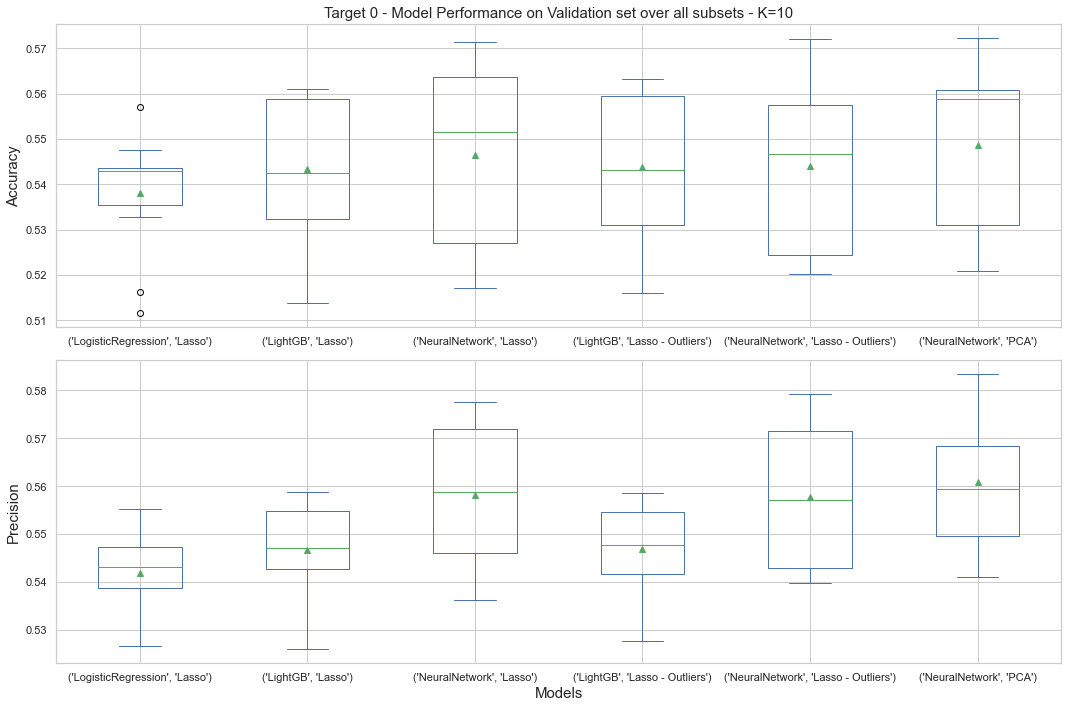

In [7]:
#set index to filter dataframe
metric = 'accuracy_test'
index_ = target_0_val.groupby(['model','subset']).mean().sort_values(by=metric, ascending=False).iloc[:10].index

#set index and filter dataframe
target_0_best = target_0_val.set_index(['model','subset'])
target_0_best = target_0_best.loc[target_0_best.index.isin(index_)]

#repeat boxplot from above  
#set ctopy of dataframe to plo
a = target_0_best.copy()
a = a.loc[a.index.isin(further_assess_target_0.index)]
#set title
title = 'Target 0 - Model Performance on Validation set over all subsets - K=10'

#set figure and size
plt.figure(figsize=(15, 10))

#set 1st subplot
ax1 = plt.subplot(2, 1, 1)

#filter dataframe to plot
df_assess = pd.DataFrame()
for model in a.index:
    df_assess[f'{model}'] = a.loc[a.index==model]['accuracy_test'].values
#plot boxplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('Accuracy', size=15)

#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
#filter dataframe to plot
df_assess = pd.DataFrame()
for model in a.index:
    df_assess[f'{model}'] = a.loc[a.index==model]['precision_test'].values
#plot boxplot
df_assess.plot(kind='box', showmeans=True,ax=ax2)
#set title and labels
ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('Precision', size=15)
plt.tight_layout()
#set path to save plot
path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_0'
name_plot = f'{path}\\{title} - Lasso .png'
# plt.savefig(name_plot, dpi=300)
#show plot
plt.show()

#### Val and Test

In [56]:
n = 7
metric = 'accuracy_test'

#set index to filter dataframe
index_ = target_0_val.groupby(['model','subset'])[['accuracy_test',
                                                    'precision_test',
                                                    'auc_test']].mean().sort_values(by=metric, ascending=False).iloc[:10].index

#set index and filter dataframe
target_0_best = target_0_val.set_index(['model','subset'])
target_0_best = target_0_best.loc[target_0_best.index.isin(index_)]
#get validation data
to_show = target_0_best.groupby(['model','subset'])[['accuracy_test',
                                                    'precision_test',
                                                    'auc_test']].mean().sort_values(by=metric, ascending=False).iloc[:6].rename(columns= ({'accuracy_test':'Accuracy',
                                                                                                                                            'precision_test':'Precision',
                                                                                                                                            'auc_test':'AUC'}))
to_show['set'] = 'Validation'

#set index to filter dataframe
index_ = target_0_val.groupby(['model','subset'])[['accuracy_test',
                                                    'precision_test',
                                                    'auc_test']].mean().sort_values(by=metric, ascending=False).iloc[:n].index
index_ = index_[index_.get_level_values(1) !='Lasso - Outliers'][:-1]


#get test data
#set index and filter dataframe
target_0_best_test = target_0_test.set_index(['model','subset'])
target_0_best_test = target_0_best_test.loc[target_0_best_test.index.isin(index_)]

to_show_test = target_0_best_test.rename(columns= ({'accuracy':'Accuracy',
                                                    'precision':'Precision',
                                                    'auc':'AUC'})).iloc[:,:n].drop(columns = 'recall')

for col in ['file','Unnamed: 0']:
    if col in to_show_test.columns:
        to_show_test = to_show_test.drop(columns = {col})
to_show_test['set'] = 'Test'

to_show_df = pd.concat([to_show,to_show_test],axis=0).reset_index().set_index(['model','subset','set']).sort_values(by=['model','subset']).unstack('set').swaplevel(axis=1).sort_index(axis=1)
# to_show_df = to_show_df.dropna()

In [14]:
n = 7
metric = 'accuracy_test'

#set index to filter dataframe
index_ = target_0_val.groupby(['model','subset']).mean().sort_values(by=metric, ascending=False).iloc[:10].index

#set index and filter dataframe
target_0_best = target_0_val.set_index(['model','subset'])
target_0_best = target_0_best.loc[target_0_best.index.isin(index_)]
#get validation data
to_show = target_0_best.groupby(['model','subset']).mean().sort_values(by=metric, ascending=False).iloc[:6][['accuracy_test',
                                                                                                             'precision_test',
                                                                                                             'auc_test']].rename(columns= ({'accuracy_test':'Accuracy',
                                                                                                                                            'precision_test':'Precision',
                                                                                                                                            'auc_test':'AUC'}))
to_show['set'] = 'Validation'

#set index to filter dataframe
index_ = target_0_val.groupby(['model','subset']).mean().sort_values(by=metric, ascending=False).iloc[:n].index
index_ = index_[index_.get_level_values(1) !='Lasso - Outliers'][:-1]


#get test data
#set index and filter dataframe
target_0_best_test = target_0_test.set_index(['model','subset'])
target_0_best_test = target_0_best_test.loc[target_0_best_test.index.isin(index_)]

to_show_test = target_0_best_test.rename(columns= ({'accuracy':'Accuracy',
                                                    'precision':'Precision',
                                                    'auc':'AUC'})).iloc[:,:n].drop(columns = 'recall')

for col in ['file','Unnamed: 0']:
    if col in to_show_test.columns:
        to_show_test = to_show_test.drop(columns = {col})
to_show_test['set'] = 'Test'

to_show_df = pd.concat([to_show,to_show_test],axis=0).reset_index().set_index(['model','subset','set']).sort_values(by=['model','subset']).unstack('set').swaplevel(axis=1).sort_index(axis=1)
# to_show_df = to_show_df.dropna()

## Import Best Models

### Perform Predictions

In [61]:
modelRaw_names, modelRaw_list, scalerRaw = importRawModels_Target_0()
x_test_stand_out = scalerRaw.transform(x_test[lasso_subset_0])



lgb_assess,assess_test_lgb = assessModelPerformance_Target0(x_train=x_test_stand_out,
                       y_true=y_test_dict['Target_0'],
                       df_target=df_target,
                       model_list=modelRaw_list,
                       model_names=modelRaw_names,
                       n=1000)

model_names, model_list, scaler = importModels_Target_0()
x_test_stand = scaler.transform(x_test[lasso_subset_0])
rest_assess,assess_test = assessModelPerformance_Target0(x_train=x_test_stand,
                       y_true=y_test_dict['Target_0'],
                       df_target=df_target,
                       model_list=model_list,
                       model_names=model_names,
                       n=1000)


assess_test['LightGB_Raw_prediction'] = assess_test_lgb['LightGB_Raw_prediction']
assess_test['LightGB_Raw_proba'] = assess_test_lgb['LightGB_Raw_proba']
lgb_assess = lgb_assess.iloc[:-1]
assess_df = pd.concat([lgb_assess,rest_assess],axis=0)
display(assess_df)

target_0_path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Assessment\Target 0\\'

cols = ['model', 'subset', 'AUC_val', 'Accuracy_val', 'Precision_val',
       'auc_test', 'accuracy_test', 'precision_test','precision_Top1000']
# assess_df[cols].to_csv(target_0_path + 'assess_df.csv')

Importing models from Target 0 - Traned with outliers
LightGB_Raw


,model,subset,AUC_val,Accuracy_val,Precision_val,auc_test,accuracy_test,precision_test,sharpeRatio,alpha,precision_Top1000,sharpeRatio_Top1000,alpha_Top1000
1,LightGB,Lasso - Outliers,0.53818,0.543789,0.546757,0.519559,0.517428,0.503211,0.203066,0.010713,0.554,3.435354,0.029295
6,Random,Lasso,0.50000,0.518071,0.518071,0.500000,0.486278,0.486278,-0.868180,0.003540,0.000,0.000000,0.000000


Importing models from Target 0
LogisticRegression
NeuralNetwork
111/111 [==============================] - 0s 472us/step
LightGB
111/111 [==============================] - 0s 422us/step


,model,subset,AUC_val,Accuracy_val,Precision_val,auc_test,accuracy_test,precision_test,sharpeRatio,alpha,precision_Top1000,sharpeRatio_Top1000,alpha_Top1000
0,LightGB,Lasso,0.537863,0.543447,0.546569,0.521275,0.519631,0.505283,0.334142,0.011136,0.571,4.536403,0.038331
2,LogisticRegression,Lasso,0.532171,0.538083,0.541866,0.515410,0.517278,0.504120,0.260566,0.011855,0.527,1.710125,0.013579
3,NeuralNetwork,Lasso,0.544646,0.546433,0.558222,0.528045,0.530098,0.519292,1.221045,0.015583,0.529,1.837214,0.013495
5,NeuralNetwork,PCA,0.547009,0.548640,0.560931,0.523021,0.525391,0.514126,0.893786,0.012774,0.522,1.392751,0.017071
6,Random,Lasso,0.500000,0.518071,0.518071,0.500000,0.486278,0.486278,-0.868180,0.003540,0.000,0.000000,0.000000


,model,subset,AUC_val,Accuracy_val,Precision_val,auc_test,accuracy_test,precision_test,sharpeRatio,alpha,precision_Top1000,sharpeRatio_Top1000,alpha_Top1000
1,LightGB,Lasso - Outliers,0.538180,0.543789,0.546757,0.519559,0.517428,0.503211,0.203066,0.010713,0.554,3.435354,0.029295
0,LightGB,Lasso,0.537863,0.543447,0.546569,0.521275,0.519631,0.505283,0.334142,0.011136,0.571,4.536403,0.038331
2,LogisticRegression,Lasso,0.532171,0.538083,0.541866,0.515410,0.517278,0.504120,0.260566,0.011855,0.527,1.710125,0.013579
3,NeuralNetwork,Lasso,0.544646,0.546433,0.558222,0.528045,0.530098,0.519292,1.221045,0.015583,0.529,1.837214,0.013495
5,NeuralNetwork,PCA,0.547009,0.548640,0.560931,0.523021,0.525391,0.514126,0.893786,0.012774,0.522,1.392751,0.017071
6,Random,Lasso,0.500000,0.518071,0.518071,0.500000,0.486278,0.486278,-0.868180,0.003540,0.000,0.000000,0.000000


### Time Analysis

#### Performing Time Analysis base on the quarter returns are realized

##### Performing time analysis based on the quarter each investment is performed

In [62]:
print('Assessng Models without outliers')
print(' ')
models_names_ = ['LogisticRegression', 'NeuralNetwork', 'LightGB', 'NeuralNetwork_PCA','Random']

value = 0.05

assess_test_ = assess_test.copy()
assess_test_['quarter'] = pd.to_datetime(assess_test_['futDate']).dt.quarter.astype(float).astype(str)
assess_test_['year'] = pd.to_datetime(assess_test_['futDate']).dt.year.astype(float).astype(str)

assess_test_lgb_ = assess_test_lgb
assess_test_lgb_['quarter'] = pd.to_datetime(assess_test_lgb_['futDate']).dt.quarter.astype(float).astype(str)
assess_test_lgb_['year'] = pd.to_datetime(assess_test_lgb_['futDate']).dt.year.astype(float).astype(str)

timeAnalysis,full_timeAssess_df = performTimeAnalysis(assess_test_,
                                                      model_list,
                                                      model_names,
                                                      models_= models_names_,
                                                      value=value)
timeAnalysis = timeAnalysis.iloc[:-1,:]

print('-'*125)
print(' ')
print('Assessng LGBM Model with outliers')
# timeAssess_df
models_names_lgb = [ 'LightGB_Raw','Random']
timeAnalysis_lgb, full_timeAssess_df_lgb= performTimeAnalysis(assess_test_lgb_,
                                                              modelRaw_list,
                                                              modelRaw_names,
                                                              models_names_lgb,
                                                              value=value)
timeAnalysis_lgb = timeAnalysis_lgb.iloc[:,:]

full_timeAssess_df = full_timeAssess_df.loc[:,full_timeAssess_df.columns.str.contains('Random')==False]

timeAssess_df = pd.concat([timeAnalysis,timeAnalysis_lgb],axis=0).drop_duplicates()
full_timeAssess_df = pd.concat([full_timeAssess_df,full_timeAssess_df_lgb],axis=1)



returns  = full_timeAssess_df.loc[:,full_timeAssess_df.columns.str.contains('returns')]
returns = returns.sort_index()
return_ = returns.loc[:,returns.columns.str.endswith('returns')]
return_ = return_.sort_index()

top50_returns = returns.loc[:,returns.columns.str.contains('Top50')]
top50_returns = top50_returns.sort_index()
top50_returns['Random_returns'] = return_['Random_returns']

target_0_time_assess_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Target 0\timeAssess_df.csv'
# timeAssess_df[['avg_precision', 'avg_accuracy','avg_top50Prec']].to_csv(target_0_time_assess_path)


#calculate ratios for whole sample 
target0_ratios = calc_AnnualizedMetrics(timeAssess_df,
                                        return_,
                                        value,
                                        sortino_thresh = value/4)

#calculate ratios for top 50
target0_ratios['sample'] = 'Whole Sample'
target0_top50Ratios = calc_AnnualizedMetrics(timeAssess_df,
                                             top50_returns,
                                            value,
                                            sortino_thresh =  value/4)
target0_top50Ratios['sample'] = 'Top 50'

target0_ratios_ = pd.concat([target0_ratios,target0_top50Ratios])
target0_ratios_ = target0_ratios_.reset_index().rename(columns = {'index': 'model'})
target0_ratios_ = target0_ratios_.set_index(['sample','model']).unstack('sample')[['annualizedSharpeRatio','annualizedSortinoRatio']]
target0_ratios_[[('adjustedSortino','Top 50'),('adjustedSortino','Whole Sample') ]] = target0_ratios_['annualizedSortinoRatio'] / np.sqrt(2)

returns_0 = pd.concat([target0_ratios,target0_top50Ratios])
returns_0 = returns_0.reset_index().rename(columns = {'index': 'model'})
returns_0 = returns_0.set_index(['sample','model']).unstack('sample')[['annualizedReturns','annualizedVolatility','negativeAnnualizedVolatility']]

display(target0_ratios_.sort_index())

print(' ')
display(returns_0.sort_index())


print(' ')
display(timeAssess_df[['avg_alpha','avg_top50Alpha']].sort_index())

cols = ['avg_auc', 'avg_precision', 'avg_accuracy','avg_top50Prec']
display(timeAssess_df[cols].sort_index())

target_0_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Target 0\\'

# target0_ratios_.to_csv(f'{target_0_path}Target_0_ratios.csv')
# returns_0.to_csv(f'{target_0_path}Target_0_returns.csv')
# timeAssess_df[['avg_alpha','avg_top50Alpha']].sort_index().to_csv(f'{target_0_path}Target_0_avgAlpha.csv')

Assessng Models without outliers
 
Performing time analysis
Annual Risk-free rate of 5.0%
Quarterly Risk-free rate of 1.25%
Calculate sharpe for portfolio generated by the whole sample
 
Calculating quarterly Sharpe
Calculating Sharpe with rfr of 1.25%
 
Calculate sharpe for portfolio generated by the top 50 observations of each quarter
 
Calculating quarterly Sharpe
Calculating Sharpe with rfr of 1.25%
 
 
-----------------------------------------------------------------------------------------------------------------------------
 
Assessng LGBM Model with outliers
Performing time analysis
Annual Risk-free rate of 5.0%
Quarterly Risk-free rate of 1.25%
Calculate sharpe for portfolio generated by the whole sample
 
Calculating quarterly Sharpe
Calculating Sharpe with rfr of 1.25%
 
Calculate sharpe for portfolio generated by the top 50 observations of each quarter
 
Calculating quarterly Sharpe
Calculating Sharpe with rfr of 1.25%
 
 
Ratios are being calculated with a annualized risk-

annualizedSharpeRatio              annualizedSortinoRatio  \
sample                            Top 50 Whole Sample                 Top 50   
model                                                                          
LightGB                         1.247131     0.775128              10.863842   
LightGB_Raw                     1.104080     0.767518               6.004535   
LogisticRegression              0.691339     0.833943               1.682383   
NeuralNetwork                   0.675841     0.842445               1.700981   
NeuralNetwork_PCA               0.629742     0.776829               1.652428   
Random                          0.546913     0.546913               1.507918   

                                adjustedSortino               
sample             Whole Sample          Top 50 Whole Sample  
model                                                         
LightGB                2.249597        7.681896     1.590705  
LightGB_Raw            2.297824        4.245848     1.624807  
LogisticRegression     2.604739        1.189624     1.841828  
NeuralNetwork          2.620383        1.202775     1.852891  
NeuralNetwork_PCA      2.511150        1.168443     1.775651  
Random                 1.507918        1.066259     1.066259

annualizedReturns              annualizedVolatility  \
sample                        Top 50 Whole Sample               Top 50   
model                                                                    
LightGB                     0.274688     0.174618             0.180164   
LightGB_Raw                 0.265739     0.174818             0.195402   
LogisticRegression          0.156821     0.185492             0.154513   
NeuralNetwork               0.149991     0.188101             0.147950   
NeuralNetwork_PCA           0.162941     0.176577             0.179345   
Random                      0.138984     0.138984             0.162703   

                                negativeAnnualizedVolatility               
sample             Whole Sample                       Top 50 Whole Sample  
model                                                                      
LightGB                0.160771                     0.020682     0.055396  
LightGB_Raw            0.162626                     0.035929     0.054320  
LogisticRegression     0.162471                     0.063494     0.052017  
NeuralNetwork          0.163928                     0.058784     0.052702  
NeuralNetwork_PCA      0.162940                     0.068349     0.050406  
Random                 0.162703                     0.059011     0.059011

,avg_alpha,avg_top50Alpha
LightGB,0.056478,0.163049
LightGB_Raw,0.057068,0.143643
LogisticRegression,0.068349,0.065309
NeuralNetwork,0.076059,0.054670
NeuralNetwork_PCA,0.065988,0.076367
Random,0.022715,0.000000


,avg_auc,avg_precision,avg_accuracy,avg_top50Prec
LightGB,0.520731,0.510797,0.517690,0.568882
LightGB_Raw,0.520612,0.509922,0.516930,0.569944
LogisticRegression,0.521879,0.517447,0.518746,0.529000
NeuralNetwork,0.533061,0.529560,0.532389,0.530938
NeuralNetwork_PCA,0.526715,0.523762,0.527047,0.528714
Random,0.500000,0.492436,0.492436,0.000000


In [107]:
target_0_Fullreturns = pd.concat([return_.iloc[:,:-1],top50_returns],axis=1)
returns_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Returns & Predictions\Target0_returns.csv'
# target_0_Fullreturns.to_csv(returns_path)
to_plot = target_0_Fullreturns.cumsum()
to_plot.iloc[-1]



LogisticRegression_returns          0.927459
NeuralNetwork_returns               0.940504
LightGB_returns                     0.873092
NeuralNetwork_PCA_returns           0.882884
LightGB_Raw_returns                 0.874091
LogisticRegression_returns_Top50    0.784106
NeuralNetwork_returns_Top50         0.749954
LightGB_returns_Top50               1.373439
NeuralNetwork_PCA_returns_Top50     0.814707
LightGB_Raw_returns_Top50           1.328696
Random_returns                      0.694922
Name: (2023.0, 1.0), dtype: float64

In [14]:
predictions_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Returns & Predictions\Target0_predictions.csv'
target0_predictions = assess_test_.copy()

target0_predictions.rename(columns = {'fillingDate':'entryDate',
                                       'futDate':'exitDate',
                                       'stockQuarterlyReturns':'stockReturns',
                                       'indexQuarterlyReturns':'indexReturns'},inplace=True)
# target0_predictions.to_csv(predictions_path)

#### Calculate Portfolio Performance using QuantStats

In [92]:
#set model names 
model_names = ['LogisticRegression', 'NeuralNetwork', 'LightGB', 'NeuralNetwork_PCA','LightGB_Raw','Random']
#set annualized rf 
rf = 0.05

qsRatios_0 = quanStats_Ratios(return_,
                              rf = rf,
                              periods_per_year = 4)
qsRatios_0['sample'] = 'Whole Sample'

qsRatios_0_top50 = quanStats_Ratios(top50_returns,
                                    rf = rf,
                                    periods_per_year = 4)
qsRatios_0_top50['sample'] = 'Top 50'
qsRatios_0_top50 = qsRatios_0_top50.loc[qsRatios_0_top50['model']!='Random']


qsRatios_0 = pd.concat([qsRatios_0,qsRatios_0_top50])
qsRatios_0.set_index(['sample','model'],inplace=True)
qsRatios_0 = qsRatios_0.unstack('sample')
display(qsRatios_0)
# qsRatios_0.to_csv(f'{target_0_path}Target_0_quanStats.csv')


sharpe              smartSharpe                sorttino  \
sample                Top 50 Whole Sample      Top 50 Whole Sample     Top 50   
model                                                                           
LightGB             1.252188     0.780795    1.086125     0.665341  10.086954   
LightGB_Raw         1.108742     0.773120    0.881880     0.645711   5.595832   
LogisticRegression  0.697235     0.839550    0.553791     0.695886   1.471424   
NeuralNetwork       0.681999     0.848003    0.588056     0.722685   1.470852   
NeuralNetwork_PCA   0.634822     0.782420    0.458127     0.634603   1.455931   
Random                   NaN     0.552513         NaN     0.471764        NaN   

                                smartSortino              adjustedSortino  \
sample             Whole Sample       Top 50 Whole Sample          Top 50   
model                                                                       
LightGB                2.036414     8.749244     1.735296        7.132554   
LightGB_Raw            2.063359     4.450856     1.723319        3.956851   
LogisticRegression     2.373891     1.168704     1.967669        1.040454   
NeuralNetwork          2.359050     1.268248     2.010430        1.040049   
NeuralNetwork_PCA      2.210754     1.050689     1.793090        1.029498   
Random                 1.298864          NaN     1.109038             NaN   

                                 
sample             Whole Sample  
model                            
LightGB                1.439962  
LightGB_Raw            1.459015  
LogisticRegression     1.678594  
NeuralNetwork          1.668100  
NeuralNetwork_PCA      1.563239  
Random                 0.918436

### Correlation between models

In [12]:
def cor_heat_map (corr, title = 'Correlation Matrix'):
    """""""""""""""""""""
    Receives 
        correlation matrix in pandas df format 
        
    Plots Correlation matrix
    
    """""""""""""""""""""
    a = plt.figure(figsize = (10, 10))
    sns.heatmap(corr, vmax = 1, vmin=-1, linewidths = 0.1,
               annot = True, annot_kws = {"size": 10}, square = True, \
                cmap=sns.diverging_palette(220, 10, as_cmap=True))
    plt.title(title, fontsize = 20)
    plt.tight_layout()
    
    path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Target 0\\'
    name_plot = f'{path}{title}.png'
    plt.savefig(name_plot, dpi=300)
    plt.show()

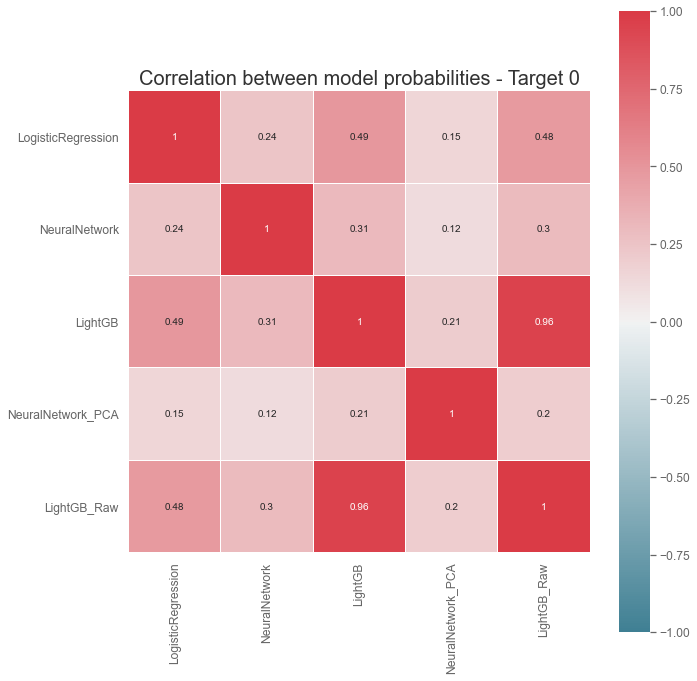

In [13]:
probabilities = assess_test.loc[:,assess_test.columns.str.contains('prob')]
for col in probabilities.columns:
    new_name = col.split('_pr')[0]
    probabilities.rename(columns={col:new_name},inplace=True)
   

title = r'Correlation between model probabilities - Target 0'
a = cor_heat_map(probabilities.corr(),title = title) 


### Calculate IC for model Alpha

In [270]:
model_name = 'LightGB_Raw'
prob_name = model_name + '_proba'
pred_name = model_name + '_prediction'
pos_df = assess_test.loc[assess_test[pred_name]==True].sort_values(ascending=False, by=prob_name)['futAlpha'].iloc[:]
neg_df= assess_test['futAlpha']
pos_bootstrap, pos_df_stats = statsTest.BootstrapSampling(pos_df, 0.15, 500)
pos_df_stats.rename(columns ={'bootStrap_mean':'Porfolios_returns'} , inplace = True)
neg_bootstrap,neg_df_stats = statsTest.BootstrapSampling(neg_df, 0.15, 500)
neg_df_stats.rename(columns ={'bootStrap_mean':'random_returns'} , inplace = True)

Confidence Intervals of the mean:
90% : [0.00515859 0.0158139 ]
95% : [0.00387899 0.01699504]
99% : [0.00183025 0.01943862]
 
Confidence Intervals of the standard deviation:
90% : [0.16566664 0.18216667]
95% : [0.16361868 0.18531646]
99% : [0.16019642 0.18999175]
Confidence Intervals of the mean:
90% : [-0.00064418  0.00765714]
95% : [-0.00178578  0.00862393]
99% : [-0.00406137  0.01043717]
 
Confidence Intervals of the standard deviation:
90% : [0.17357808 0.18649403]
95% : [0.17172756 0.18816685]
99% : [0.16937205 0.19243071]


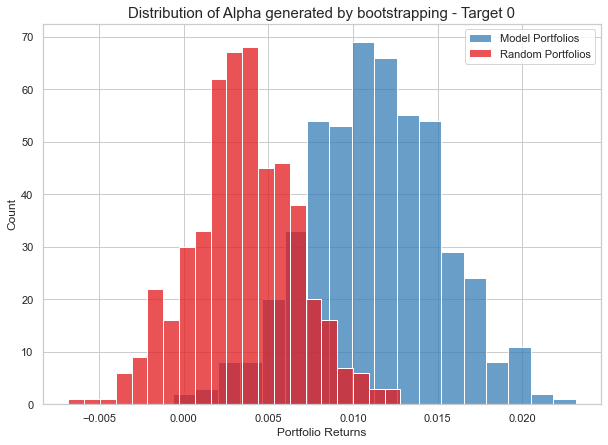

In [265]:
plt.figure(figsize = (10,7))
title = 'Distribution of Alpha generated by bootstrapping - Target 0'
sns.histplot(x= 'Porfolios_returns', data = pos_df_stats, color = palette[1], label = 'Model Portfolios',legend=True)
sns.histplot(x= 'random_returns', data = neg_df_stats, color = palette[0], label = 'Random Portfolios', legend=True)

plt.title( title,size = 15)
plt.legend()
plt.xlabel('Portfolio Returns')
plt.show()

### Feature Importance 

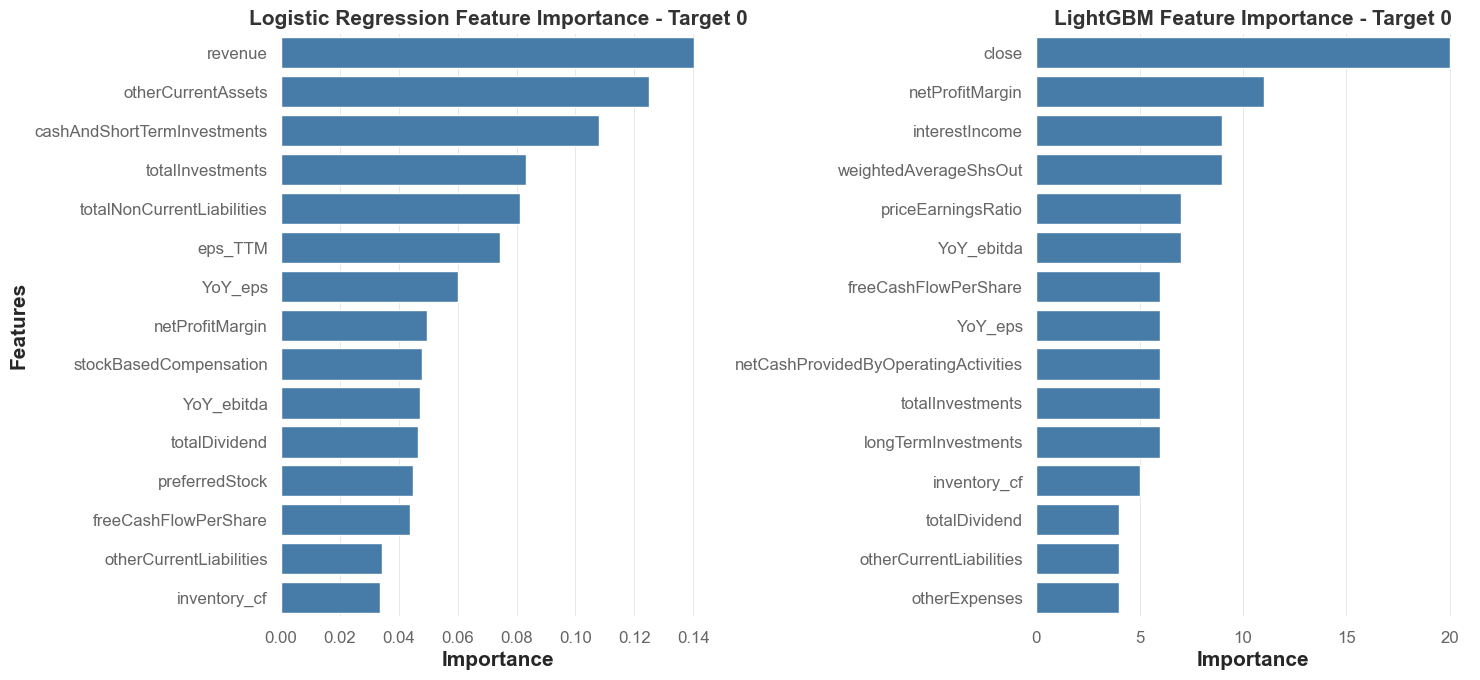

In [70]:
""""""""""""""""
plot feature importance for LGBM and logistic regression
"""""""""""""""""""""
lr_model_0 = model_list[0]
lgb_model_0 = model_list[2]  

model_features = lr_model_0.feature_names_in_   

ft_importance = pd.DataFrame(index = model_features)    
ft_importance['LogisticRegression'] = lr_model_0.coef_[0]   
ft_importance['LightGBM'] = lgb_model_0.feature_importances_    


plt.figure(figsize = (15,7),)

ax1 = plt.subplot(1, 2, 1)
to_plot_0 = abs(ft_importance['LogisticRegression'].sort_values(ascending=True)).iloc[-15:].sort_values(ascending=False)


sns.barplot(x = to_plot_0.values, y =to_plot_0.index,ax=ax1, color = palette[1])

ax2 = plt.subplot(1, 2, 2)

to_plot = abs(ft_importance['LightGBM'].sort_values(ascending=True)).iloc[-15:].sort_values(ascending=False)

sns.barplot(x = to_plot.values, y =to_plot.index,ax=ax2, color = palette[1])

ax1.set_title('Logistic Regression Feature Importance - Target 0', size = 15, weight = 'bold')
ax2.set_title('LightGBM Feature Importance - Target 0', size = 15,weight = 'bold')
ax1.set_ylabel('Features',size = 15,weight = 'bold')
ax1.set_xlabel('Importance',size = 15,weight = 'bold')
ax2.set_xlabel('Importance',size = 15,weight = 'bold')
plt.tight_layout()

path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Results'
finalTitle = r'Target0_FeatureImportance'
name_plot = f'{path}\\{finalTitle}.png'
plt.savefig(name_plot, dpi=600)

plt.show()

In [72]:
common_fts = []
for ft_ in to_plot_0.index:
     if ft_ in to_plot.index:
         common_fts.append(ft_) 
         
         
print(common_fts)

['totalInvestments', 'YoY_eps', 'netProfitMargin', 'YoY_ebitda', 'totalDividend', 'freeCashFlowPerShare', 'otherCurrentLiabilities', 'inventory_cf']


In [30]:
from sklearn.inspection import PartialDependenceDisplay

clf = model_list[0] 

features = [0, 1, (0, 1)]

X = preprocess.standardize(x_train_out[lasso_subset_0])
PartialDependenceDisplay.from_estimator(clf,X , features)

KeyboardInterrupt: 

### Statistical tests - Assess model relative performance

#### Nemeny Test

Test if there's statistical difference between the performers of the classifiers  

H0: Performance Model(i) == Performance Model(j)  
H1: Performance Model(i) != Performance Model(j)

In [20]:
statsTest_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\StatisticalTests\\'

from scipy import stats
import scikit_posthocs as sp
cols = [ 'auc_test', 'accuracy_test','precision_test',]
nemeny_data = assess_df
nemeny_data['index'] = nemeny_data['model'] +   '_' + nemeny_data['subset']
nemeny_data = nemeny_data.set_index(['index'])[cols].T.iloc[:,:-1]
nemeny_data_ = sp.posthoc_nemenyi_friedman(nemeny_data,)
nemeny_data_['Target'] = 'Target 0'
# nemeny_data_.to_csv(f'{statsTest_path}nemenyTest_Target0.csv')
display(nemeny_data_)

,LightGB_Lasso - Outliers,LightGB_Lasso,LogisticRegression_Lasso,NeuralNetwork_Lasso,NeuralNetwork_PCA,Target
LightGB_Lasso - Outliers,1.000000,0.819212,0.900000,0.073839,0.370022,Target 0
LightGB_Lasso,0.819212,1.000000,0.672674,0.526141,0.900000,Target 0
LogisticRegression_Lasso,0.900000,0.672674,1.000000,0.036466,0.235184,Target 0
NeuralNetwork_Lasso,0.073839,0.526141,0.036466,1.000000,0.900000,Target 0
NeuralNetwork_PCA,0.370022,0.900000,0.235184,0.900000,1.000000,Target 0


##### T-Test (Two-Sided)

Test if there's statistical difference between the performers of the classifiers a

H0: Performance Model(i) == Performance Model(j)  
H1: Performance Model(i) != Performance Model(j)

In [67]:
import HypothesisTesting as hyp

cols = [ 'auc_test', 'accuracy_test','precision_test',]
nemeny_data = assess_df
nemeny_data['index'] = nemeny_data['model'] +   '_' + nemeny_data['subset']
nemeny_data = nemeny_data.set_index(['index'])[cols].T
table_list = []
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,s1)
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 0'

# consecutive_tTest.to_excel(f'{statsTest_path}\TTest_Target0.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-sided
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.005287364773326936
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.5394723154248954
Performing T Test
Type of test: two-sided
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.029911488549301826
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.07526577327061042
Performing T Test
Type of test: two-sided
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.035535528639942894
Performing T Test
Type of test: two-sided
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.005287364773326936
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: n

index,LightGB_Lasso - Outliers,LightGB_Lasso,LogisticRegression_Lasso,NeuralNetwork_Lasso,NeuralNetwork_PCA,Random_Lasso,Target
index,,,,,,,
LightGB_Lasso - Outliers,1.000000,0.005287,0.539472,0.029911,0.075266,0.035536,Target 0
LightGB_Lasso,0.005287,1.000000,0.157026,0.037977,0.117606,0.031375,Target 0
LogisticRegression_Lasso,0.539472,0.157026,1.000000,0.003616,0.007159,0.047505,Target 0
NeuralNetwork_Lasso,0.029911,0.037977,0.003616,1.000000,0.000743,0.017283,Target 0
NeuralNetwork_PCA,0.075266,0.117606,0.007159,0.000743,1.000000,0.024347,Target 0
Random_Lasso,0.035536,0.031375,0.047505,0.017283,0.024347,1.000000,Target 0


#### __On returns__

#### T-Test (Two-Sided)

Test if portfolio returns from model i are statistically higher than returns from model j

H0: Returns Model(i) == Returns Model(j)  
H1: Returns Model(i) != Returns Model(j)

In [68]:
import HypothesisTesting as hyp


table_list = []
nemeny_data = return_.iloc[:,:-1]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,s1)
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns,
                                 columns= nemeny_data.columns,
                                 data = table_list)    


consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 0'

# consecutive_tTest.to_excel(f'{statsTest_path}\TTest - Model\TTest_Returns_Target0.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.7917739245139546
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.08908259711455409
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.20882869999667053
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.09644920114555362
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.7917739245139546
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.10821950176095521
Performing T Test
Type of test: two-sided
We dont 

,LogisticRegression_returns,NeuralNetwork_returns,LightGB_returns,NeuralNetwork_PCA_returns,LightGB_Raw_returns,Target
LogisticRegression_returns,1.000000,0.791774,0.089083,0.208829,0.096449,Target 0
NeuralNetwork_returns,0.791774,1.000000,0.108220,0.214207,0.079951,Target 0
LightGB_returns,0.089083,0.108220,1.000000,0.823615,0.952613,Target 0
NeuralNetwork_PCA_returns,0.208829,0.214207,0.823615,1.000000,0.807811,Target 0
LightGB_Raw_returns,0.096449,0.079951,0.952613,0.807811,1.000000,Target 0


#### T-Test (Right Tai)

Test if there's statistical difference between the returns of portfolios generated by each classifier

H0: Returns Model(i) <= Returns Model(j)  
H1: Returns Model(i) > Returns Model(j)

In [23]:
import HypothesisTesting as hyp


table_list = []
nemeny_data = return_.iloc[:,:-1]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,
                                   s1,
                                   'greater')
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns,
                                 columns= nemeny_data.columns,
                                 data = table_list)    


consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 0'

# consecutive_tTest.to_excel(f'{statsTest_path}TTest_Returns_Greater_Target0.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.6041130377430227
Performing T Test
Type of test: greater
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.044541298557277044
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.10441434999833527
Performing T Test
Type of test: greater
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.04822460057277681
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.3958869622569773
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.054109750880477606
Performing T Test
Type of test: greater


,LogisticRegression_returns,NeuralNetwork_returns,LightGB_returns,NeuralNetwork_PCA_returns,LightGB_Raw_returns,Target
LogisticRegression_returns,1.000000,0.604113,0.044541,0.104414,0.048225,Target 0
NeuralNetwork_returns,0.395887,1.000000,0.054110,0.107103,0.039976,Target 0
LightGB_returns,0.955459,0.945890,1.000000,0.588192,0.523694,Target 0
NeuralNetwork_PCA_returns,0.895586,0.892897,0.411808,1.000000,0.403906,Target 0
LightGB_Raw_returns,0.951775,0.960024,0.476306,0.596094,1.000000,Target 0


#### Two Sided T-Test - Benchmark

Test if returns from model generated portfolio are statistically different than returns from the benchmark  

H0: Returns Model == Returns Benchmark  
H1: Returns Model != Returns Benchmark  

In [24]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_.iloc[:,:]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,s1,)
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 0'
consecutive_tTest = consecutive_tTest.iloc[:-1,-2:].rename(columns = {'Random_returns':'PValue'})
# consecutive_tTest.to_excel(f'{statsTest_path}TTest_ReturnsBenchmark_TwoSided_Target0.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.7917739245139546
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.08908259711455409
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.20882869999667053
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.09644920114555362
Performing T Test
Type of test: two-sided
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.0001976818405750661
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.7917739245139546
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-

,PValue,Target
LogisticRegression_returns,0.000198,Target 0
NeuralNetwork_returns,0.000005,Target 0
LightGB_returns,0.000146,Target 0
NeuralNetwork_PCA_returns,0.000679,Target 0
LightGB_Raw_returns,0.000100,Target 0


#### Right Tail T-test - Benchmark

Test if returns from models are higher than returns from the benchmark

H0: Returns Model(i) <= Benchmark  
H1: Returns Model(i) > Benchmark

In [26]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_.iloc[:,:]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,s1,'greater')
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 0'
consecutive_tTest = consecutive_tTest.iloc[:-1,-2:].rename(columns = {'Random_returns':'PValue'})
# consecutive_tTest.to_excel(f'{statsTest_path}TTest_ReturnsBenchmark_Greater_Target0.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.6041130377430227
Performing T Test
Type of test: greater
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.044541298557277044
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.10441434999833527
Performing T Test
Type of test: greater
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.04822460057277681
Performing T Test
Type of test: greater
We reject the null hypothesis with a level of confidence of 95%
P-Value: 9.884092028753305e-05
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.3958869622569773
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of t

,PValue,Target
LogisticRegression_returns,0.000099,Target 0
NeuralNetwork_returns,0.000002,Target 0
LightGB_returns,0.000073,Target 0
NeuralNetwork_PCA_returns,0.000339,Target 0
LightGB_Raw_returns,0.000050,Target 0


#### Two Sided Willcox

Test if returns from model generated portfolio are statistically different than returns from the benchmark  

H0: Returns Model == Returns Benchmark  
H1: Returns Model != Returns Benchmark  

In [41]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_.iloc[:,:]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        
        if s0.values[0] != s1.values[0]:
            tTest, pValue = hyp.wilcox_test(s0,s1,)
        
            model_list.append(pValue)
        else:
            model_list.append(1)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 0'
# consecutive_tTest = consecutive_tTest.iloc[:-1,-2:].rename(columns = {'Random_returns':'PValue'})
consecutive_tTest.to_excel(f'{statsTest_path}Willcox_ReturnsBenchmark_TwoSided_Target0.xlsx')
display(consecutive_tTest)

Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.5958194732666016
Performing two-sided Wilcox Test.
 
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.03623390197753906
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.21616744995117188
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.069580078125
Performing two-sided Wilcox Test.
 
We reject the null hypothesis with a level of confidence of 95%
P-Value: 8.20159912109375e-05
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.5958194732666016
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.1230926513671875
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.3299827575683594
Performing two-sided Wilcox Test.
 
We dont reje

,LogisticRegression_returns,NeuralNetwork_returns,LightGB_returns,NeuralNetwork_PCA_returns,LightGB_Raw_returns,Random_returns,Target
LogisticRegression_returns,1.000000,0.595819,0.036234,0.216167,0.069580,0.000082,Target 0
NeuralNetwork_returns,0.595819,1.000000,0.123093,0.329983,0.097307,0.000006,Target 0
LightGB_returns,0.036234,0.123093,1.000000,0.812355,0.784126,0.000105,Target 0
NeuralNetwork_PCA_returns,0.216167,0.329983,0.812355,1.000000,0.545876,0.000063,Target 0
LightGB_Raw_returns,0.069580,0.097307,0.784126,0.545876,1.000000,0.000105,Target 0
Random_returns,0.000082,0.000006,0.000105,0.000063,0.000105,1.000000,Target 0


#### Right Tail Willcox

Test if portfolio returns from model i are statistically higher than returns from model j

H0: Returns Model(i) <= Returns Model(j)  
H1: Returns Model(i) > Returns Model(j)

In [42]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_.iloc[:,:]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        
        if s0.values[0] != s1.values[0]:
            tTest, pValue = hyp.wilcox_test(s0,s1,
                                            'greater')
        
            model_list.append(pValue)
        else:
            model_list.append(1)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 0'
# consecutive_tTest = consecutive_tTest.iloc[:-1,-2:].rename(columns = {'Random_returns':'PValue'})
consecutive_tTest.to_excel(f'{statsTest_path}WillCox_ReturnsBenchmark_Greater_Target0.xlsx')
display(consecutive_tTest)

Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.7147016525268555
Performing greater Wilcox Test.
 
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.01811695098876953
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.10808372497558594
Performing greater Wilcox Test.
 
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.0347900390625
Performing greater Wilcox Test.
 
We reject the null hypothesis with a level of confidence of 95%
P-Value: 4.100799560546875e-05
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.2979097366333008
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.06154632568359375
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.1649913787841797
Performing greater Wilcox Test.
 
We reject the n

,LogisticRegression_returns,NeuralNetwork_returns,LightGB_returns,NeuralNetwork_PCA_returns,LightGB_Raw_returns,Random_returns,Target
LogisticRegression_returns,1.000000,0.714702,0.018117,0.108084,0.034790,0.000041,Target 0
NeuralNetwork_returns,0.297910,1.000000,0.061546,0.164991,0.048654,0.000003,Target 0
LightGB_returns,0.983616,0.943007,1.000000,0.607937,0.392063,0.000052,Target 0
NeuralNetwork_PCA_returns,0.898775,0.844103,0.406178,1.000000,0.272938,0.000031,Target 0
LightGB_Raw_returns,0.968139,0.955153,0.621917,0.739163,1.000000,0.000052,Target 0
Random_returns,0.999969,0.999998,0.999959,0.999976,0.999959,1.000000,Target 0


# Target 15

#### Validation Data 

In [10]:
target_15_validation = target_15_val[['model','subset','auc_test','precision_test']].groupby(['model','subset']).mean().unstack('model')

#### Avg Accuracy and Precision for Target 0 - Validation set

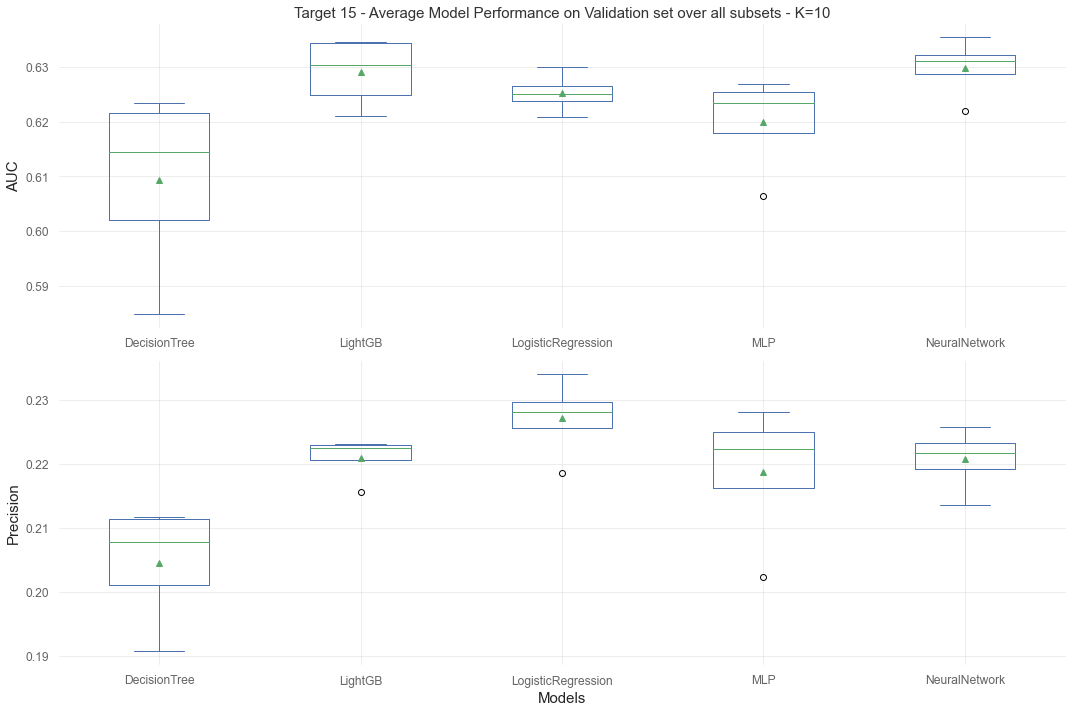

In [ ]:
#set copy of dataframe to plot
a = target_15_validation.copy()

#set title
title = 'Target 15 - Average Model Performance on Validation set over all subsets - K=10'

#set figure and size
plt.figure(figsize=(15, 10))

#set 1st subplot
ax1 = plt.subplot(2, 1, 1)

#filter dataframe to plot
df_assess = a['auc_test']
#plot boxplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('AUC', size=15)

#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
#filter dataframe to plot
df_assess = a['precision_test']
#plot boxplot
df_assess.plot(kind='box', showmeans=True,ax=ax2)
#set title and labels
ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('Precision', size=15)
plt.tight_layout()
#set path to save plot
path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Target 15'
name_plot = f'{path}\\{title}.png'
# plt.savefig(name_plot, dpi=300)
#show plot
plt.show()

#### Subset performance 

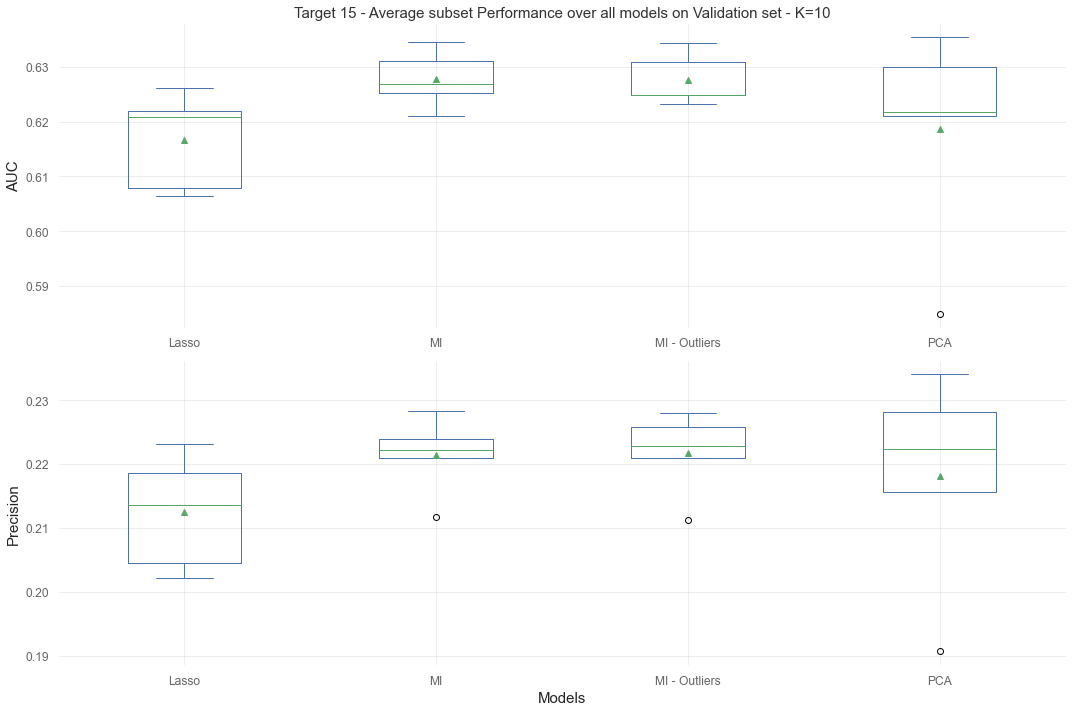

In [13]:
#set copy of dataframe to plot
a = target_15_validation.copy()

#set title
title = 'Target 15 - Average subset Performance over all models on Validation set - K=10'

#set figure and size
plt.figure(figsize=(15, 10))

#set 1st subplot
ax1 = plt.subplot(2, 1, 1)

#filter dataframe to plot
df_assess = a['auc_test'].T
#plot boxplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('AUC', size=15)

#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
#filter dataframe to plot
df_assess = a['precision_test'].T
#plot boxplot
df_assess.plot(kind='box', showmeans=True,ax=ax2)
#set title and labels
ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('Precision', size=15)
plt.tight_layout()
#set path to save plot
path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Target 15'
name_plot = f'{path}\\{title}.png'
plt.savefig(name_plot, dpi=300)
#show plot
plt.show()

#### Define models that will be further assessed

In [8]:
target_15_further_assess = target_15_val.groupby(['model','subset']).mean().sort_values(by='auc_test', ascending=False).iloc[:7]['auc_test']

display(target_15_further_assess)
# target_15_further_assess.to_csv(r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Target 15\furtherAssess_models.csv')

model               subset       
NeuralNetwork       PCA              0.635422
LightGB             MI               0.634524
                    MI - Outliers    0.634337
NeuralNetwork       MI               0.631163
                    MI - Outliers    0.630910
LogisticRegression  PCA              0.629931
MLP                 MI               0.626841
Name: auc_test, dtype: float64

#### Plot best models

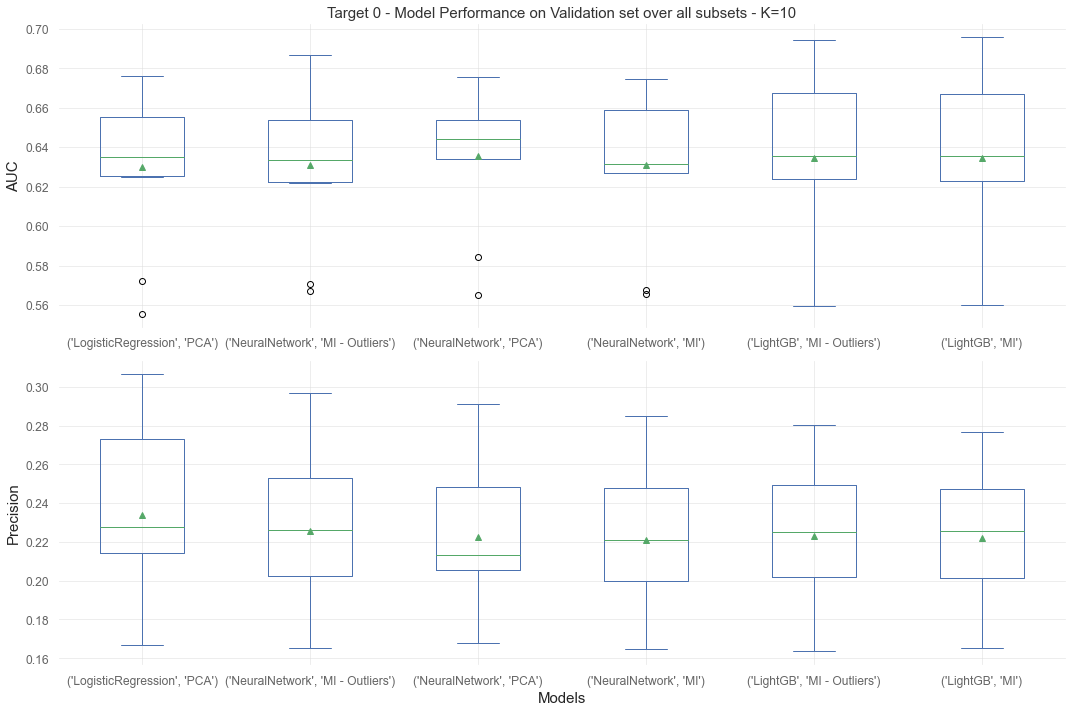

In [ ]:
#set index to filter dataframe
index_ = target_15_val.groupby(['model','subset']).mean().sort_values(by='auc_test', ascending=False).iloc[:6].index

#set index and filter dataframe
target_15_best = target_15_val.set_index(['model','subset'])
target_15_best = target_15_best.loc[target_15_best.index.isin(index_)].sort_values(by = 'precision_test', ascending=False)

#repeat boxplot from above  
#set ctopy of dataframe to plo
a = target_15_best.copy()

#set title
title = 'Target 0 - Model Performance on Validation set over all subsets - K=10'

#set figure and size
plt.figure(figsize=(15, 10))

#set 1st subplot
ax1 = plt.subplot(2, 1, 1)

#filter dataframe to plot
df_assess = pd.DataFrame()
for model in a.index:
    df_assess[f'{model}'] = a.loc[a.index==model]['auc_test'].values
#plot boxplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('AUC', size=15)

#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
#filter dataframe to plot
df_assess = pd.DataFrame()
for model in a.index:
    df_assess[f'{model}'] = a.loc[a.index==model]['precision_test'].values
#plot boxplot
df_assess.plot(kind='box', showmeans=True,ax=ax2)
#set title and labels
ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('Precision', size=15)
plt.tight_layout()
#set path to save plot
path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_0'
name_plot = f'{path}\\{title} - Lasso .png'
# plt.savefig(name_plot, dpi=300)
#show plot
plt.show()

### Set best models

In [9]:
index_ = target_15_val.groupby(['model','subset']).mean().sort_values(by='auc_test', ascending=False).iloc[:6].index

#set index and filter dataframe
target_15_best = target_15_val.set_index(['model','subset'])
target_15_best = target_15_best.loc[target_15_best.index.isin(index_)].sort_values(by = 'precision_test', ascending=False)


n = 7
to_show = target_15_best.groupby(['model','subset']).mean().sort_values(by='auc_test', ascending=False).iloc[:n][['accuracy_test','precision_test','auc_test','recall_test']].rename(columns= ({'accuracy_test':'Accuracy',
                                                                                                                                                                                                'precision_test':'Precision',
                                                                                                                                                                                                'auc_test':'AUC',
                                                                                                                                                                                                'recall_test':'recall'}))
to_show['set'] = 'Validation'

# #set index to filter dataframe
index_ = target_15_val.groupby(['model','subset']).mean().sort_values(by='auc_test', ascending=False).iloc[:n+1].index
index_ = index_[index_.get_level_values(1) !='Lasso - Outliers'][:]

# #set index and filter dataframe
target_15_best_test = target_15_test.set_index(['model','subset'])
target_15_best_test = target_15_best_test.loc[target_15_best_test.index.isin(index_)]

to_show_test = target_15_best_test.rename(columns= ({'accuracy':'Accuracy','precision':'Precision','auc':'AUC'})).iloc[:,:n]
to_show_test = to_show_test.loc[to_show_test.index.get_level_values(1) !='MI - Outliers'].sort_values(by='AUC', ascending=False)


for col in ['file','Unnamed: 0']:
    if col in to_show_test.columns:
        to_show_test = to_show_test.drop(columns = {col})
to_show_test['set'] = 'Test'

to_show_df = pd.concat([to_show,to_show_test],axis=0).reset_index().set_index(['model','subset','set']).sort_values(by=['model','subset']).unstack('set').swaplevel(axis=1).sort_index(axis=1)
to_show_df = to_show_df.drop(columns =[('Validation','index'), ( 'Test','index')] ).dropna()

## Import Best Models

In [72]:
def importTarget_15_models ():
    print('Import models for Target 15')
    import joblib
    model_list_15 = []
    model_names = ['MLP.pkl','NeuralNetwork.pkl','LightGB.pkl','NeuralNetwork_PCA.pkl','LogisticRegression_PCA.pkl']
    path = r'D:\Thesis Reseearch\Research\Thesis\Tables\Target_15\Models\Final Models\\'
    for  model_name in model_names:
        model_clone = joblib.load(f'{path}{model_name}')
        
        model_list_15.append(model_clone)
        
    scaler = joblib.load(f'{path}scaler.pkl')

    model_names_15 = ['MLP','NeuralNetwork','LightGB','NeuralNetwork_PCA','LogisticRegression_PCA']
    
    return model_list_15, scaler, model_names_15


model_list_15, scaler, model_names_15 = importTarget_15_models()

Import models for Target 15


### Perform Predictions on Test Set

In [79]:
model_list_15, scaler, model_names_15 = importTarget_15_models()
n = 100

x_test_stand_15 = scale_MI(x_test[mi_subset_15],scaler)
y_true = y_test_dict['Target_0.15']


assess_df_15, assess_test_15 = assessModelPerformance_Target_15( x_train =x_test_stand_15 ,
                                  y_true = y_true,
                                  df_target=df_target,
                                  model_list = model_list_15, 
                                  model_names = model_names_15,
                                  n=n)

target_15_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Target 15\\'
cols = ['model', 'subset',
       'auc_test','precision_test','recall_test','precision_top1000']


assess_df_15 = assess_df_15[cols].dropna()
display(assess_df_15)
# assess_df_15[cols].dropna().to_csv(f'{target_15_path}assess_df_15.csv')

Import models for Target 15
MLP
NeuralNetwork
312/312 [==============================] - 0s 395us/step
LightGB
NeuralNetwork_PCA
(19968, 53)
312/312 [==============================] - 0s 376us/step
LogisticRegression_PCA
(19968, 53)


,model,subset,auc_val,precision_val,auc_test,precision_test,recall_test,alpha_test,precision_top1000,alpha_top1000,recall_val
0,LightGB,Lasso,0.537863,0.546569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LightGB,Lasso - Outliers,0.538180,0.546757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LogisticRegression,Lasso,0.532171,0.541866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NeuralNetwork,Lasso,0.544646,0.558222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NeuralNetwork,Lasso - Outliers,0.542811,0.557749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NeuralNetwork,PCA,0.547009,0.560931,0.607748,0.217167,0.506195,0.013392,0.282,0.032558,NaN
6,MLP,MI,NaN,NaN,0.620036,0.225477,0.530248,0.014085,0.345,0.069047,NaN
7,NeuralNetwork,MI,NaN,NaN,0.624774,0.214772,0.597668,0.011090,0.302,0.041224,NaN
8,LightGB,MI,NaN,NaN,0.632938,0.212705,0.647959,0.011803,0.329,0.057221,NaN
9,LogisticRegression,PCA,NaN,NaN,0.613136,0.229252,0.487245,0.017110,0.285,0.052968,NaN


,model,subset,auc_test,precision_test,recall_test,precision_top1000
5,NeuralNetwork,PCA,0.607748,0.217167,0.506195,0.282
6,MLP,MI,0.620036,0.225477,0.530248,0.345
7,NeuralNetwork,MI,0.624774,0.214772,0.597668,0.302
8,LightGB,MI,0.632938,0.212705,0.647959,0.329
9,LogisticRegression,PCA,0.613136,0.229252,0.487245,0.285
10,Random,MI,0.500000,0.137420,1.000000,0.000


In [17]:
model_list_15, scaler, model_names_15 = importTarget_15_models()
n = 100

x_test_stand_15 = scale_MI(x_test[mi_subset_15],scaler)
y_true = y_test_dict['Target_0.15']


assess_df_15, assess_test_15 = assessModelPerformance_Target_15 ( x_train =x_test_stand_15 ,
                                  y_true = y_true,
                                  df_target=df_target,
                                  model_list = model_list_15, 
                                  model_names = model_names_15,
                                  n=n)

target_15_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Target 15\\'
cols = ['model', 'subset', 'auc_val', 'precision_val', 'recall_val',
       'auc_test','precision_test','recall_test','precision_top1000']


assess_df_15 = assess_df_15[cols].dropna()
display(assess_df_15)
# assess_df_15[cols].dropna().to_csv(f'{target_15_path}assess_df_15.csv')

Import models for Target 15
MLP
NeuralNetwork
312/312 [==============================] - 0s 1ms/step
LightGB
NeuralNetwork_PCA
(19968, 53)
312/312 [==============================] - 0s 934us/step
LogisticRegression_PCA
(19968, 53)


,model,subset,auc_val,precision_val,recall_val,auc_test,precision_test,recall_test,alpha_test,precision_top1000,alpha_top1000
0,LightGB,MI,0.634524,0.222205,0.699215,0.632938,0.212705,0.647959,0.011803,0.329,0.057221
1,LogisticRegression,PCA,0.629931,0.234048,0.627572,0.613136,0.229252,0.487245,0.017110,0.285,0.052968
2,NeuralNetwork,MI,0.631163,0.220980,0.692668,0.624774,0.214772,0.597668,0.011090,0.302,0.041224
3,NeuralNetwork,PCA,0.635422,0.222387,0.703781,0.607748,0.217167,0.506195,0.013392,0.282,0.032558
4,MLP,MI,NaN,NaN,NaN,0.620036,0.225477,0.530248,0.014085,0.345,0.069047
5,Random,MI,0.500000,0.142039,1.000000,0.500000,0.137420,1.000000,0.003540,0.000,0.000000


,model,subset,auc_val,precision_val,recall_val,auc_test,precision_test,recall_test,precision_top1000
0,LightGB,MI,0.634524,0.222205,0.699215,0.632938,0.212705,0.647959,0.329
1,LogisticRegression,PCA,0.629931,0.234048,0.627572,0.613136,0.229252,0.487245,0.285
2,NeuralNetwork,MI,0.631163,0.220980,0.692668,0.624774,0.214772,0.597668,0.302
3,NeuralNetwork,PCA,0.635422,0.222387,0.703781,0.607748,0.217167,0.506195,0.282
5,Random,MI,0.500000,0.142039,1.000000,0.500000,0.137420,1.000000,0.000


### Time Analysis

In [80]:
value = 0.05

assess_test_15_ = assess_test_15.copy()
assess_test_15_['quarter'] = pd.to_datetime(assess_test_15_['futDate']).dt.quarter.astype(float).astype(str)
assess_test_15_['year'] = pd.to_datetime(assess_test_15_['futDate']).dt.year.astype(float).astype(str)


models_ = ['MLP','NeuralNetwork','LightGB','NeuralNetwork_PCA','LogisticRegression_PCA','Random']
timeassess_df_15,timeAssess_df_15 = performTimeAnalysis(assess_test_15_,
                                                                   model_list_15,
                                                                   model_names_15,
                                                                   models_,
                                                                   value = value)
# timeassess_df_15 = timeassess_df_15.drop(columns = ['sharpe','top50_Sharpe','avg_accuracy'])


returns  = timeAssess_df_15.loc[:,timeAssess_df_15.columns.str.contains('returns')]
return_15 = returns.loc[:,returns.columns.str.endswith('returns')]
top50_returns_15 = returns.loc[:,returns.columns.str.contains('Top50')]
top50_returns_15['Random_returns'] = return_15['Random_returns']


target15_ratios = calc_AnnualizedMetrics(timeassess_df_15, return_15, value,value)
target15_ratios['sample'] = 'Whole Sample'
target15_top50Ratios = calc_AnnualizedMetrics(timeassess_df_15, top50_returns_15, value,value)
target15_top50Ratios['sample'] = 'Top 50'

target15_ratios_ = pd.concat([target15_ratios,target15_top50Ratios])
target15_ratios_ = target15_ratios_.reset_index().rename(columns = {'index': 'model'})
target15_ratios_ = target15_ratios_.set_index(['sample','model']).round(4).unstack('sample')[['annualizedSharpeRatio','annualizedSortinoRatio']]
target15_ratios_[[('adjustedSortino','Top 50'),('adjustedSortino','Whole Sample') ]] = target15_ratios_['annualizedSortinoRatio'] / np.sqrt(2)

returns_15 = pd.concat([target15_ratios,target15_top50Ratios])
returns_15 = returns_15.reset_index().rename(columns = {'index': 'model'})
returns_15 = returns_15.set_index(['sample','model']).round(4).unstack('sample')[['annualizedReturns','annualizedVolatility','negativeAnnualizedVolatility']]

display(target15_ratios_.sort_index())
print(' ')
display(returns_15.sort_index())

print(' ')
display(timeassess_df_15[['avg_alpha','avg_top50Alpha']].sort_index())

cols = ['avg_auc', 'avg_precision', 'avg_recall','avg_top50Prec']

display(timeassess_df_15[cols].sort_index())

# timeassess_df_15[cols].sort_index().to_csv(f'{target_15_path}timeAssess_df.csv')
# target15_ratios_.to_csv(f'{target_15_path}Target_15_ratios.csv')
# returns_15.to_csv(f'{target_15_path}Target_15_returns.csv')
# timeassess_df_15[['avg_alpha','avg_top50Alpha']].sort_index().to_csv(f'{target_15_path}Target_15_avgAlpha.csv')

Performing time analysis
Annual Risk-free rate of 5.0%
Quarterly Risk-free rate of 1.25%
Calculate sharpe for portfolio generated by the whole sample
 
Calculating quarterly Sharpe
Calculating Sharpe with rfr of 1.25%
 
Calculate sharpe for portfolio generated by the top 50 observations of each quarter
 
Calculating quarterly Sharpe
Calculating Sharpe with rfr of 1.25%
 
 
Ratios are being calculated with a annualized risk-free rate return of 5.0%
Quarterly risk-free rate return is 1.25%
Negative volatility is being calculated with a threshold of 5.0%
Ratios are being calculated with a annualized risk-free rate return of 5.0%
Quarterly risk-free rate return is 1.25%
Negative volatility is being calculated with a threshold of 5.0%


annualizedSharpeRatio               \
sample                                Top 50 Whole Sample   
model                                                       
LightGB                               1.0638       0.6971   
LogisticRegression_PCA                0.8191       0.7934   
MLP                                   1.0007       0.7032   
NeuralNetwork                         1.0942       0.6712   
NeuralNetwork_PCA                     1.2034       0.7694   
Random                                0.5469       0.5469   

                       annualizedSortinoRatio              adjustedSortino  \
sample                                 Top 50 Whole Sample          Top 50   
model                                                                        
LightGB                                3.2564       1.5478        2.302623   
LogisticRegression_PCA                 2.5598       1.9889        1.810052   
MLP                                    2.8059       1.5690        1.984071   
NeuralNetwork                          3.6108       1.4837        2.553221   
NeuralNetwork_PCA                      3.8000       1.9052        2.687006   
Random                                 1.0381       1.0381        0.734048   

                                     
sample                 Whole Sample  
model                                
LightGB                    1.094460  
LogisticRegression_PCA     1.406365  
MLP                        1.109451  
NeuralNetwork              1.049134  
NeuralNetwork_PCA          1.347180  
Random                     0.734048

annualizedReturns              annualizedVolatility  \
sample                            Top 50 Whole Sample               Top 50   
model                                                                        
LightGB                           0.3518       0.1944               0.2837   
LogisticRegression_PCA            0.2703       0.2238               0.2689   
MLP                               0.3550       0.2036               0.3048   
NeuralNetwork                     0.3710       0.1895               0.2933   
NeuralNetwork_PCA                 0.3304       0.2049               0.2330   
Random                            0.1390       0.1390               0.1627   

                                    negativeAnnualizedVolatility               
sample                 Whole Sample                       Top 50 Whole Sample  
model                                                                          
LightGB                      0.2072                       0.0927       0.0933  
LogisticRegression_PCA       0.2190                       0.0861       0.0874  
MLP                          0.2185                       0.1087       0.0979  
NeuralNetwork                0.2078                       0.0889       0.0940  
NeuralNetwork_PCA            0.2013                       0.0738       0.0813  
Random                       0.1627                       0.0857       0.0857

,avg_alpha,avg_top50Alpha
LightGB,0.049644,0.186117
LogisticRegression_PCA,0.072639,0.128301
MLP,0.059755,0.188273
NeuralNetwork,0.044883,0.191096
NeuralNetwork_PCA,0.061032,0.165000
Random,0.022715,0.000000


,avg_auc,avg_precision,avg_recall,avg_top50Prec
LightGB,0.626687,0.215054,0.634497,0.336071
LogisticRegression_PCA,0.617839,0.232409,0.495493,0.260667
MLP,0.631667,0.230792,0.551283,0.324739
NeuralNetwork,0.619600,0.214744,0.589696,0.315000
NeuralNetwork_PCA,0.608472,0.215265,0.510113,0.292000
Random,0.500000,0.140245,1.000000,0.000000


#### Calculate QuantStats Ratios

In [91]:
model_names = ['MLP','NeuralNetwork','LightGB','NeuralNetwork_PCA','LogisticRegression_PCA','Random']
rf = 0.05
periods_per_year = 4
qsRatios_15 = quanStats_Ratios(return_15,  rf = 0.05, periods_per_year = 4)
qsRatios_15['sample'] = 'Whole Sample'

qsRatios_15_top50 = quanStats_Ratios(top50_returns_15,
                                    rf = rf,
                                    periods_per_year = periods_per_year)
qsRatios_15_top50['sample'] = 'Top 50'
qsRatios_15_top50 = qsRatios_15_top50.loc[qsRatios_15_top50['model']!='Random']


qsRatios_15 = pd.concat([qsRatios_15,qsRatios_15_top50])
qsRatios_15.set_index(['sample','model'],inplace=True)
qsRatios_15 = qsRatios_15.unstack('sample')
display(qsRatios_15)
# qsRatios_15.to_csv(f'{target_15_path}Target_15_quanStats.csv')

sharpe              smartSharpe               \
sample                    Top 50 Whole Sample      Top 50 Whole Sample   
model                                                                    
LightGB                 1.067031     0.701478    0.826186     0.697380   
LogisticRegression_PCA  0.822479     0.797577    0.802867     0.797225   
MLP                     1.003725     0.707325    0.798154     0.683981   
NeuralNetwork           1.097281     0.675590    0.844342     0.671652   
NeuralNetwork_PCA       1.207302     0.773879    1.072895     0.745566   
Random                       NaN     0.552513         NaN     0.486509   

                        sorttino              smartSortino               \
sample                    Top 50 Whole Sample       Top 50 Whole Sample   
model                                                                     
LightGB                 4.284140     1.904063     3.317147     1.892939   
LogisticRegression_PCA  3.338786     2.577542     3.259173     2.576406   
MLP                     3.395415     1.894522     2.700006     1.831997   
NeuralNetwork           4.830539     1.820498     3.717032     1.809886   
NeuralNetwork_PCA       5.460219     2.485232     4.852341     2.394308   
Random                       NaN     1.298864          NaN     1.143700   

                       adjustedSortino               
sample                          Top 50 Whole Sample  
model                                                
LightGB                       3.029345     1.346376  
LogisticRegression_PCA        2.360878     1.822597  
MLP                           2.400921     1.339630  
NeuralNetwork                 3.415707     1.287287  
NeuralNetwork_PCA             3.860958     1.757324  
Random                             NaN     0.918436

In [ ]:
target15_Fullreturns = pd.concat([return_15.iloc[:,:-1],top50_returns_15],axis=1)
returns_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Returns & Predictions\Target15_returns.csv'
# target15_Fullreturns.sort_index().to_csv(returns_path)

In [ ]:
predictions_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\Returns & Predictions\Target15_predictions.csv'
target15_predictions = assess_test_15_.copy()

target15_predictions.rename(columns = {'fillingDate':'entryDate',
                                       'futDate':'exitDate',
                                       'stockQuarterlyReturns':'stockReturns',
                                       'indexQuarterlyReturns':'indexReturns'},inplace=True)
# target15_predictions.to_csv(predictions_path)

### Model Probabilities

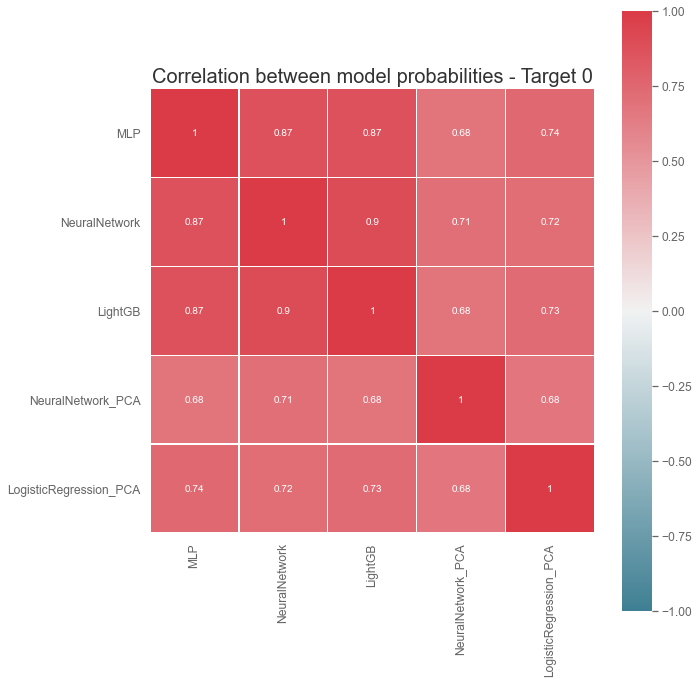

In [ ]:
probabilities = assess_test_15.loc[:,assess_test_15.columns.str.contains('prob')]
for col in probabilities.columns:
    new_name = col.split('_pr')[0]
    probabilities.rename(columns={col:new_name},inplace=True)
   

title = 'Correlation between model probabilities - Target 0'
cor_heat_map(probabilities.corr(),title = title) 


### Calculate IC for each

In [ ]:
model_name = 'NeuralNetwork'
prob_name = model_name + '_proba'
pred_name = model_name + '_prediction'
pos_df = assess_test_15.loc[assess_test_15[pred_name]==True].sort_values(ascending=False, by=prob_name)['futAlpha'].iloc[:]
neg_df= assess_test_15['futAlpha']
pos_bootstrap, pos_df_stats = statsTest.BootstrapSampling(pos_df, 0.15, 500)
pos_df_stats.rename(columns ={'bootStrap_mean':'Porfolios_returns'} , inplace = True)
neg_bootstrap,neg_df_stats = statsTest.BootstrapSampling(neg_df, 0.15, 500)
neg_df_stats.rename(columns ={'bootStrap_mean':'random_returns'} , inplace = True)

Confidence Intervals of the mean:
90% : [0.00162003 0.02029572]
95% : [-0.00119928  0.02354837]
99% : [-0.00539432  0.02821715]
 
Confidence Intervals of the standard deviation:
90% : [0.23365454 0.25659185]
95% : [0.23064564 0.26008641]
99% : [0.22439318 0.26531858]
Confidence Intervals of the mean:
90% : [-0.00020311  0.00766787]
95% : [-0.0016126   0.00873203]
99% : [-0.0035025   0.01040273]
 
Confidence Intervals of the standard deviation:
90% : [0.17455067 0.18656897]
95% : [0.17265517 0.18859488]
99% : [0.1702968 0.19231  ]


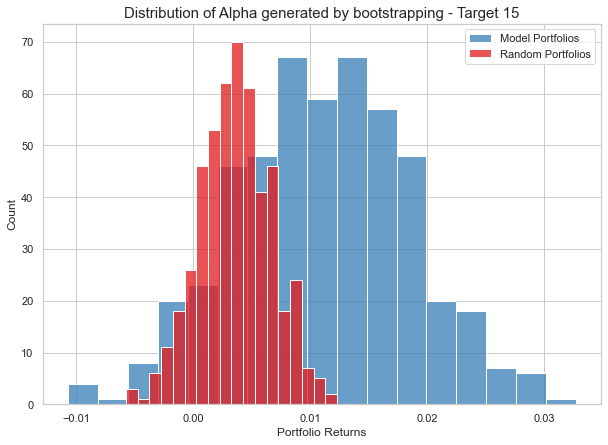

In [ ]:
plt.figure(figsize = (10,7))
title = 'Distribution of Alpha generated by bootstrapping - Target 15'
sns.histplot(x= 'Porfolios_returns', data = pos_df_stats, color = palette[1], label = 'Model Portfolios',legend=True)
sns.histplot(x= 'random_returns', data = neg_df_stats, color = palette[0], label = 'Random Portfolios', legend=True)

plt.title( title,size = 15)
plt.legend()
plt.xlabel('Portfolio Returns')
plt.show()

### Feature Importance 

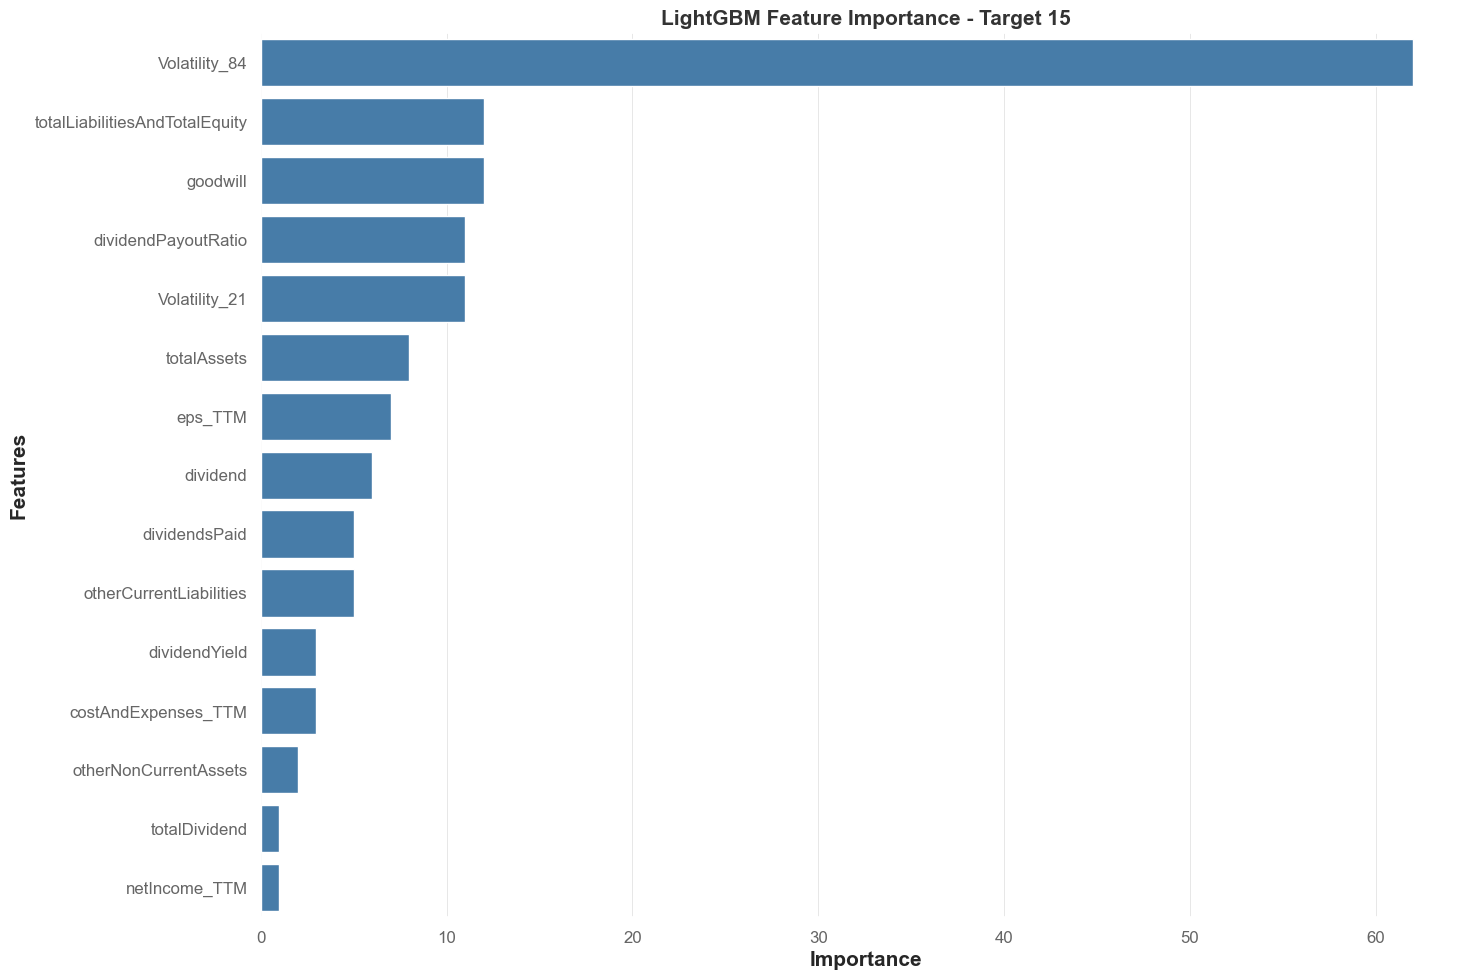

In [83]:
""""""""""""""""
plot feature importance for LGBM and logistic regression
"""""""""""""""""""""
lr_model_15 = model_list_15[-1]
lgb_model_15 = model_list_15[2]

model_features_15 = lgb_model_15.feature_name_   
ft_importance_15 = pd.DataFrame(index = model_features_15)    
ft_importance_15['LightGBM'] = lgb_model_15.feature_importances_    


plt.figure(figsize = (15,10),)

ax1 = plt.subplot(1, 1, 1)
to_plot_15 = abs(ft_importance_15['LightGBM'].sort_values(ascending=True)).iloc[-15:].sort_values(ascending=False)
sns.barplot(x = to_plot_15.values, y =to_plot_15.index,ax=ax1, color = palette[1])


model_features_15 = lr_model_15.feature_names_in_   
ft_importance_15 = pd.DataFrame(index = model_features_15)    
ft_importance_15['LogisticRegression'] = lr_model_15.coef_[0]   


ax1.set_title('LightGBM Feature Importance - Target 15', size = 15,weight = 'bold')
ax1.set_ylabel('Features',size = 15,weight = 'bold')
ax1.set_xlabel('Importance',size = 15,weight = 'bold')


plt.tight_layout()

path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Results'
finalTitle = r'Target15_FeatureImportance'
name_plot = f'{path}\\{finalTitle}.png'
plt.savefig(name_plot, dpi=600)
plt.show()

### Statistical Test

#### Nemeny Test

Test if there's statistical difference between the performers of the classifiers  

H0: Performance Model(i) == Performance Model(j)  
H1: Performance Model(i) != Performance Model(j)

In [64]:
statsTest_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment\StatisticalTests\\'

from scipy import stats
import scikit_posthocs as sp
cols = [ 'precision_val',
       'precision_test',]
nemeny_data = assess_df_15
nemeny_data['index'] = nemeny_data['model'] +   '_' + nemeny_data['subset']
nemeny_data = nemeny_data.set_index(['index'])[cols].T.iloc[:,:-1]
nemeny_data_ = sp.posthoc_nemenyi_friedman(nemeny_data,)
nemeny_data_['Target'] = 'Target 15'
nemeny_data_.to_csv(f'{statsTest_path}nemenyTest_Target15.csv')
display(nemeny_data_)

,LightGB_MI,LogisticRegression_PCA,NeuralNetwork_MI,NeuralNetwork_PCA,Target
LightGB_MI,1.000000,0.212847,0.900000,0.632975,Target 15
LogisticRegression_PCA,0.212847,1.000000,0.212847,0.850366,Target 15
NeuralNetwork_MI,0.900000,0.212847,1.000000,0.632975,Target 15
NeuralNetwork_PCA,0.632975,0.850366,0.632975,1.000000,Target 15


### On Returns

#### Two-Sided T-Test

Test if returns of each model are statistically different from other models  


H0: Returns_Model(i) == Returns_Model(j)  
H1: Returns_Model(i) != Returns_Model(j)  

In [69]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_15.iloc[:,:-1]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,s1,)
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 15'

# consecutive_tTest.to_excel(f'{statsTest_path}TTest_Returns_Target15.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.14590776226876603
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.35556737600085386
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.937949986281743
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.12987435286368537
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.14590776226876603
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.3333737604107979
Performing T Test
Type of test: two-sided
We dont r

,MLP_returns,NeuralNetwork_returns,LightGB_returns,NeuralNetwork_PCA_returns,LogisticRegression_PCA_returns,Target
MLP_returns,1.000000,0.145908,0.355567,0.937950,0.129874,Target 15
NeuralNetwork_returns,0.145908,1.000000,0.333374,0.185504,0.004493,Target 15
LightGB_returns,0.355567,0.333374,1.000000,0.386989,0.038735,Target 15
NeuralNetwork_PCA_returns,0.937950,0.185504,0.386989,1.000000,0.162390,Target 15
LogisticRegression_PCA_returns,0.129874,0.004493,0.038735,0.162390,1.000000,Target 15


#### Right Tail T-Test

Test if returns of model i are statistically higher than from model j


H0: Returns_Model(i) <= Returns_Model(j)  
H1: Returns_Model(i) > Returns_Model(j)  

In [70]:
import HypothesisTesting as hyp


table_list = []
nemeny_data = return_15.iloc[:,1:-1]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,
                                   s1,
                                   'greater')
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns,
                                 columns= nemeny_data.columns,
                                 data = table_list)    


consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 15'

# consecutive_tTest.to_excel(f'{statsTest_path}TTest_Returns_Greater_Target15.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.8333131197946011
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.9072478278953756
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.9977534485751559
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.16668688020539896
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.8065056315200316
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.9806324587033088
Performing T Test
Type of test: greater
We dont reject H0 with a leve

,NeuralNetwork_returns,LightGB_returns,NeuralNetwork_PCA_returns,LogisticRegression_PCA_returns,Target
NeuralNetwork_returns,1.000000,0.833313,0.907248,0.997753,Target 15
LightGB_returns,0.166687,1.000000,0.806506,0.980632,Target 15
NeuralNetwork_PCA_returns,0.092752,0.193494,1.000000,0.918805,Target 15
LogisticRegression_PCA_returns,0.002247,0.019368,0.081195,1.000000,Target 15


#### Two Sided T-Test - Benchmark

Test if returns from model generated portfolio are statistically different than returns from the benchmark  

H0: Returns Model == Returns Benchmark  
H1: Returns Model != Returns Benchmark  

In [56]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_15.iloc[:,1:]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,s1,)
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 15'
consecutive_tTest = consecutive_tTest.iloc[:-1,-2:].rename(columns = {'Random_returns':'PValue'})
# consecutive_tTest.to_excel(f'{statsTest_path}TTest_ReturnsBenchmark_TwoSided_Target15.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.3333737604107979
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.18550434420924877
Performing T Test
Type of test: two-sided
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.004493102849688315
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.19854517076964254
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.3333737604107979
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: two-sided
We dont reject H0 with a level of confidence of 95%
P-Value: 0.38698873695993663
Performing T Test
Type of test: two-s

,PValue,Target
NeuralNetwork_returns,0.198545,Target 15
LightGB_returns,0.151794,Target 15
NeuralNetwork_PCA_returns,0.048237,Target 15
LogisticRegression_PCA_returns,0.055144,Target 15


#### Right Tail T-test - Benchmark

Test if returns from model generated portfolio are statistically greater than returns from the benchmark  


H0: Returns Model <= Returns Benchmark  
H1: Returns Model > Returns Benchmark  

In [55]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_15.iloc[:,1:]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        tTest, pValue = hyp.T_Test(s0,s1,'greater')
        
        model_list.append(pValue)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 15'
consecutive_tTest = consecutive_tTest.iloc[:-1,-2:].rename(columns = {'Random_returns':'PValue'})
# consecutive_tTest.to_excel(f'{statsTest_path}TTest_ReturnsBenchmark_Greater_Target15.xlsx')
display(consecutive_tTest)

Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.8333131197946011
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.9072478278953756
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.9977534485751559
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.09927258538482127
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.16668688020539896
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: nan
Performing T Test
Type of test: greater
We dont reject H0 with a level of confidence of 95%
P-Value: 0.8065056315200316
Performing T Test
Type of test: greater
We dont reject H0 with a lev

,PValue,Target
NeuralNetwork_returns,0.099273,Target 15
LightGB_returns,0.075897,Target 15
NeuralNetwork_PCA_returns,0.024119,Target 15
LogisticRegression_PCA_returns,0.027572,Target 15


In [50]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_15.iloc[:,1:]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        
        if s0.values[0] != s1.values[0]:
            tTest, pValue = hyp.wilcox_test(s0,s1,)
        
            model_list.append(pValue)
        else:
            model_list.append(1)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 15'
consecutive_tTest.to_excel(f'{statsTest_path}Willcox_ReturnsBenchmark_TwoSided_Target15.xlsx')
display(consecutive_tTest)

Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.6215133666992188
Performing two-sided Wilcox Test.
 
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.04405403137207031
Performing two-sided Wilcox Test.
 
We reject the null hypothesis with a level of confidence of 95%
P-Value: 0.005580902099609375
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.2773551940917969
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.6215133666992188
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.2773551940917969
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.058258056640625
Performing two-sided Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.26109886169433594
Performing two-sided Wilcox Test.
 
We reject

,NeuralNetwork_returns,LightGB_returns,NeuralNetwork_PCA_returns,LogisticRegression_PCA_returns,Random_returns,Target
NeuralNetwork_returns,1.000000,0.621513,0.044054,0.005581,0.277355,Target 15
LightGB_returns,0.621513,1.000000,0.277355,0.058258,0.261099,Target 15
NeuralNetwork_PCA_returns,0.044054,0.277355,1.000000,0.311794,0.032768,Target 15
LogisticRegression_PCA_returns,0.005581,0.058258,0.311794,1.000000,0.048441,Target 15
Random_returns,0.277355,0.261099,0.032768,0.048441,1.000000,Target 15


Test if returns from model i generated portfolio are statistically greater than returns from model j  


H0: Returns Model i <= Returns Model j   
H1: Returns Model i > Returns Model j

In [48]:
import HypothesisTesting as hyp

table_list = []
nemeny_data = return_15.iloc[:,1:]
for col in nemeny_data.columns:
    s0 = nemeny_data[col]
    model_list = []
    for col_1 in nemeny_data.columns:
        s1 = nemeny_data[col_1]
        
        if s0.values[0] != s1.values[0]:
            tTest, pValue = hyp.wilcox_test(s0,s1,
                                            'greater')
        
            model_list.append(pValue)
        else:
            model_list.append(1)
        
    table_list.append(model_list)

consecutive_tTest = pd.DataFrame(index= nemeny_data.columns, columns= nemeny_data.columns, data = table_list)    
consecutive_tTest = consecutive_tTest.fillna(1)  
consecutive_tTest['Target'] = 'Target 15'
# consecutive_tTest = consecutive_tTest.iloc[:-1,-2:].rename(columns = {'Random_returns':'PValue'})
consecutive_tTest.to_excel(f'{statsTest_path}WillCox_ReturnsBenchmark_Greater_Target15.xlsx')
display(consecutive_tTest)

Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.7020902633666992
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.9800052642822266
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.9975700378417969
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.13867759704589844
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.3107566833496094
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.869450569152832
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.9734153747558594
Performing greater Wilcox Test.
 
We dont reject H0 with a level of confidence of 95%
P-Value: 0.13054943084716797
Performing greater Wilcox Test.
 
We reject the null hypothesis with a level of confide

,NeuralNetwork_returns,LightGB_returns,NeuralNetwork_PCA_returns,LogisticRegression_PCA_returns,Random_returns,Target
NeuralNetwork_returns,1.000000,0.702090,0.980005,0.997570,0.138678,Target 15
LightGB_returns,0.310757,1.000000,0.869451,0.973415,0.130549,Target 15
NeuralNetwork_PCA_returns,0.022027,0.138678,1.000000,0.852874,0.016384,Target 15
LogisticRegression_PCA_returns,0.002790,0.029129,0.155897,1.000000,0.024220,Target 15
Random_returns,0.869451,0.877256,0.985212,0.977973,1.000000,Target 15


# Full Comparison

#### Assess Benchmarks Performance

In [52]:
def quanStats_FundRatios (returns,rf = 0.05, periods_per_year = 4 ):
    import quantstats as qs
    
    #set list to store data
    data_list = []
    
    for col in returns.columns:
         
        portfolioReturns = returns[col]
        
        sharpe = qs.stats.sharpe(portfolioReturns,
                                rf=rf,
                                periods=periods_per_year,
                                annualize=True,)
        
        smartSharpe = qs.stats.smart_sharpe(portfolioReturns,
                                rf=rf,
                                periods=periods_per_year,
                                annualize=True,)
        sorttino = qs.stats.sortino(portfolioReturns,
                                rf=rf,
                                periods=periods_per_year,
                                annualize=True,)
        
        smartSortino = qs.stats.smart_sortino(portfolioReturns,
                                                rf=rf,
                                                periods=periods_per_year,
                                                annualize=True,)
        adjustedSortino =  qs.stats.adjusted_sortino(portfolioReturns,
                                                    periods=periods_per_year,
                                                    rf =rf)
        
        annualizedVolatility = qs.stats.volatility(portfolioReturns,
                                                periods=periods_per_year,)
        
        tdd_ = qs.stats.calc_TDD(portfolioReturns,
                                 rf=rf,
                                 periods=4,
                                 annualize=True,)
        
        ratios_dict = {}
        ratios_dict['model'] = col
        ratios_dict['sharpe'] = sharpe
        ratios_dict['smartSharpe'] = smartSharpe
        ratios_dict['sorttino'] = sorttino
        ratios_dict['smartSortino'] = smartSortino
        ratios_dict['adjustedSortino'] = adjustedSortino
        ratios_dict['TDD'] = tdd_
        
        data_list.append(ratios_dict)
    return(pd.DataFrame(data_list))


import sys
sys.path.insert(1, r'C:\Users\rafae\Personal\Github\GCP-Stock_Market\FMP_API')
sys.path.insert(2, r'C:\Users\rafae\Personal\Github\GCP-Stock_Market\InsertData')

import FMP_API as API


#set key
key = '54594d7278e0fa3c0831a72c60e04b8d'

#get ticker object
tickerAPI = API.getSymbols(key)

#get tickers
sp_tickers = tickerAPI.get_SP()
nasqad_tickers = tickerAPI.get_NASQAD()

In [66]:
df_full_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Sample\LongTerm-DataPreparation.csv'

df_model_raw = pd.read_csv(df_full_path).set_index(['symbol', 'date', 'fillingDate', 'year', 'quarter'])
df_model_raw = df_model_raw.loc[df_model_raw.index.isin(x_test.index)]
df_model_raw = df_model_raw.sort_values(['symbol','date'])

In [141]:
data_quarter = assess_test_.sort_values(['symbol','date']).copy()
data_quarter['marketCapitalization'] = df_model_raw['marketCapitalization'].values
data_quarter['priceEarningsRatio'] = df_model_raw['priceEarningsRatio'].values

quarter_list = data_quarter.reset_index()['quarter'].unique()
year_list= data_quarter.reset_index()['year'].unique()

timeAssess_list = []

#for each period 
for year in year_list:
    for quarter in quarter_list:

        #set qury to filter dataset
        quarter_query = data_quarter.loc[(data_quarter['quarter']==quarter)&(data_quarter['year']==year)]
        #filter dataset
        df_temp = data_quarter.loc[quarter_query.index]
        
        sp_bench = df_temp.loc[df_temp['symbol'].isin(sp_tickers)]
        nasqad_bench = df_temp.loc[df_temp['symbol'].isin(nasqad_tickers)]
        megaCap_bench = df_temp.sort_values('marketCapitalization',ascending=False).iloc[:50]
        pe_bench = df_temp.loc[df_temp['priceEarningsRatio']>0].sort_values('priceEarningsRatio',
                                                                            ascending=True).iloc[:50]
        lgbm_strategy = df_temp.sort_values('LightGB_proba',
                                            ascending=False).iloc[:50]
        
        peNN_strategy = df_temp.loc[(df_temp['NeuralNetwork_prediction']==1)&
                                   (df_temp['NeuralNetwork_PCA_prediction']==1)].sort_values('NeuralNetwork_PCA_proba',
                                                                                            ascending=False).iloc[:200]
#         print(megaCap_bench.symbol)
        if len(df_temp)>0:
            data_dict = dict()
            data_dict['year'] = year
            data_dict['quarter'] = quarter
            data_dict['random_returns'] = df_temp['stockQuarterlyReturns'].sample(100,
                                                                                  replace= True,
                                                                                  random_state=0).mean()
            data_dict['sp_returns'] = sp_bench['stockQuarterlyReturns'].mean()
            data_dict['nasqad_returns'] = nasqad_bench['stockQuarterlyReturns'].mean()
            data_dict['megaCap_returns'] = megaCap_bench['stockQuarterlyReturns'].mean()
            data_dict['pe_returns'] = pe_bench['stockQuarterlyReturns'].mean()
            data_dict['lgbm_returns'] = lgbm_strategy['stockQuarterlyReturns'].mean()
            data_dict['peNN_returns'] = peNN_strategy['stockQuarterlyReturns'].mean()
            timeAssess_list.append(data_dict)
        

#### Subset Performance

Accuracy


subset
Lasso               0.538143
Lasso - Outliers    0.536861
PCA                 0.533955
MI                  0.529675
dtype: float64

Precision


subset
MI               0.627768
MI - Outliers    0.627660
PCA              0.618611
Lasso            0.616654
dtype: float64

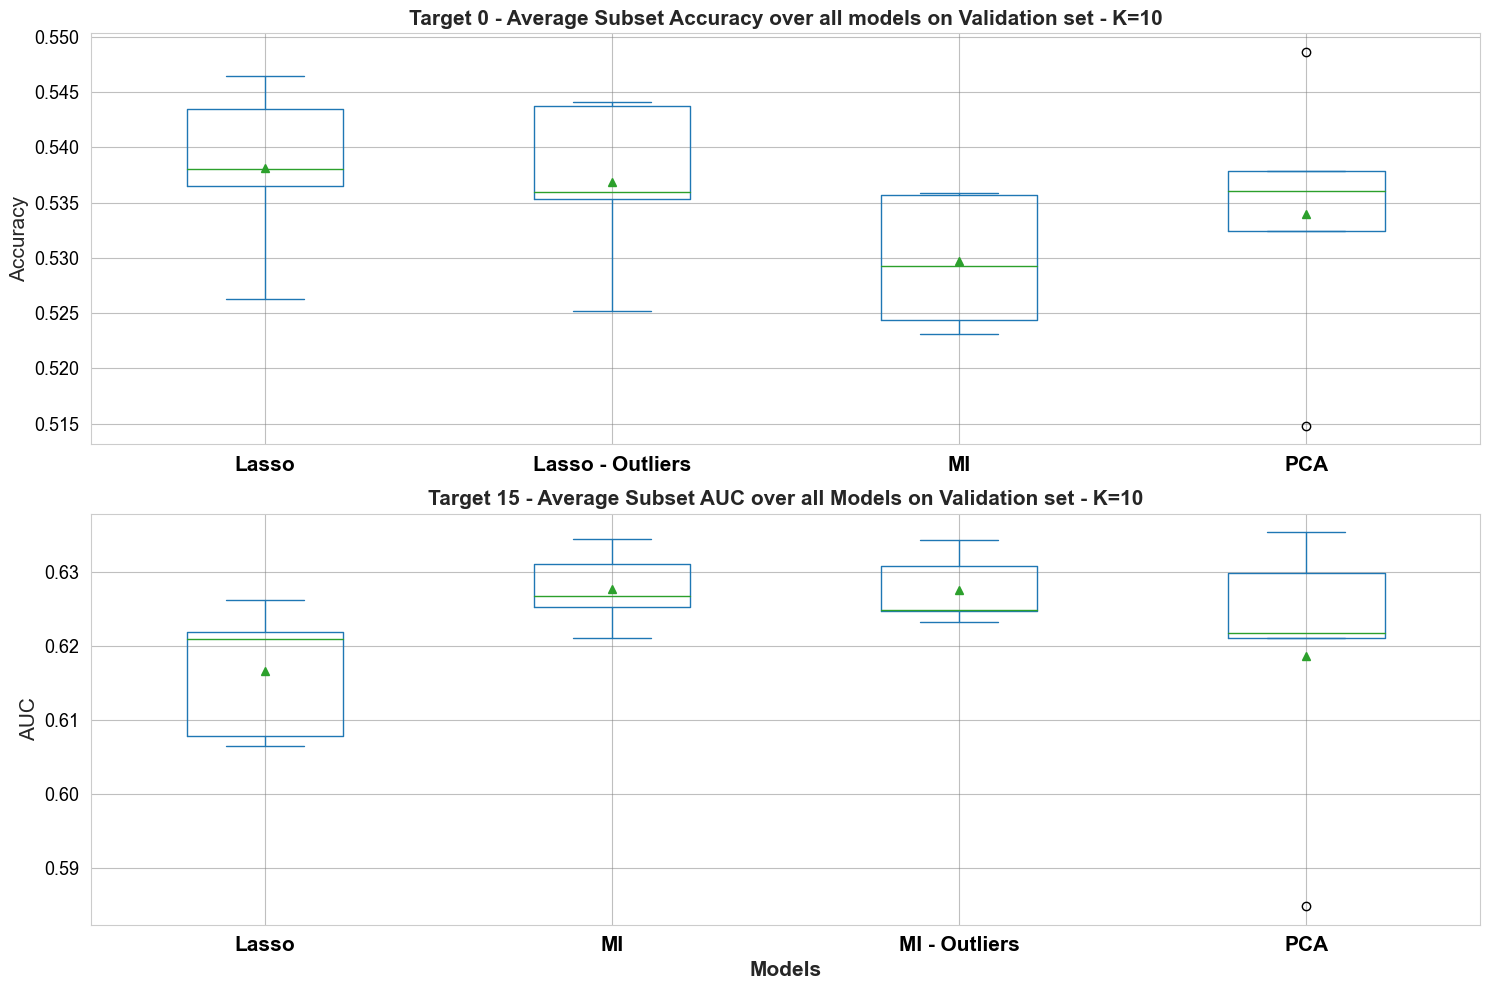

In [38]:
#set copy of dataframe to plot
a = target_0_validation.copy()


#set title
title = 'Target 0 - Average Subset Accuracy over all models on Validation set - K=10'

#set figure and size
plt.figure(figsize=(15, 10))

#set 1st subplot
ax1 = plt.subplot(2, 1, 1)

#filter dataframe to plot
df_assess = a['accuracy_test'].T

print('Accuracy')
display(df_assess.mean().sort_values(ascending=False))
#plot boxplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('Accuracy', size=15)
ax1.set_title(title,size=15, weight = 'bold')

ax1.tick_params(axis='x', labelsize=15, labelrotation=0, which='both', width=1, direction='out', pad=5, colors='black', grid_color='grey', grid_alpha=0.5)
for label in ax1.get_xticklabels():
    label.set_weight("bold")
ax1.tick_params(axis='y', labelsize=13, labelrotation=0, which='both', width=1, direction='out', pad=5, colors='black', grid_color='grey', grid_alpha=0.5)
title = 'Target 15 - Average Subset AUC over all Models on Validation set - K=10'
a = target_15_validation.copy()
#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
#filter dataframe to plot
df_assess = a['auc_test'].T
print('Precision')
display(df_assess.mean().sort_values(ascending=False))
#plot boxplot
df_assess.plot(kind='box', showmeans=True,ax=ax2)
#set title and labels
ax2.set_xlabel('Models', size=15,weight = 'bold')
ax2.set_ylabel('AUC', size=15)
ax2.set_title(title,size=15,weight = 'bold')
ax2.tick_params(axis='x', labelsize=15, labelrotation=0, which='both', width=1, direction='out', pad=5, colors='black', grid_color='grey', grid_alpha=0.5)
ax2.tick_params(axis='y', labelsize=13, labelrotation=0, which='both', width=1, direction='out', pad=5, colors='black', grid_color='grey', grid_alpha=0.5)
for label in ax2.get_xticklabels():
    label.set_weight("bold")

plt.tight_layout()
#set path to save plot
path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Results'
finalTitle = r'SubsetAveragePerformance'
name_plot = f'{path}\\{finalTitle}.png'
plt.savefig(name_plot, dpi=600)
#show plot
plt.show()

### Model Performance

#### In Bold

Precision


model
DecisionTree          0.609259
LightGB               0.629037
LogisticRegression    0.625223
MLP                   0.620006
NeuralNetwork         0.629841
dtype: float64

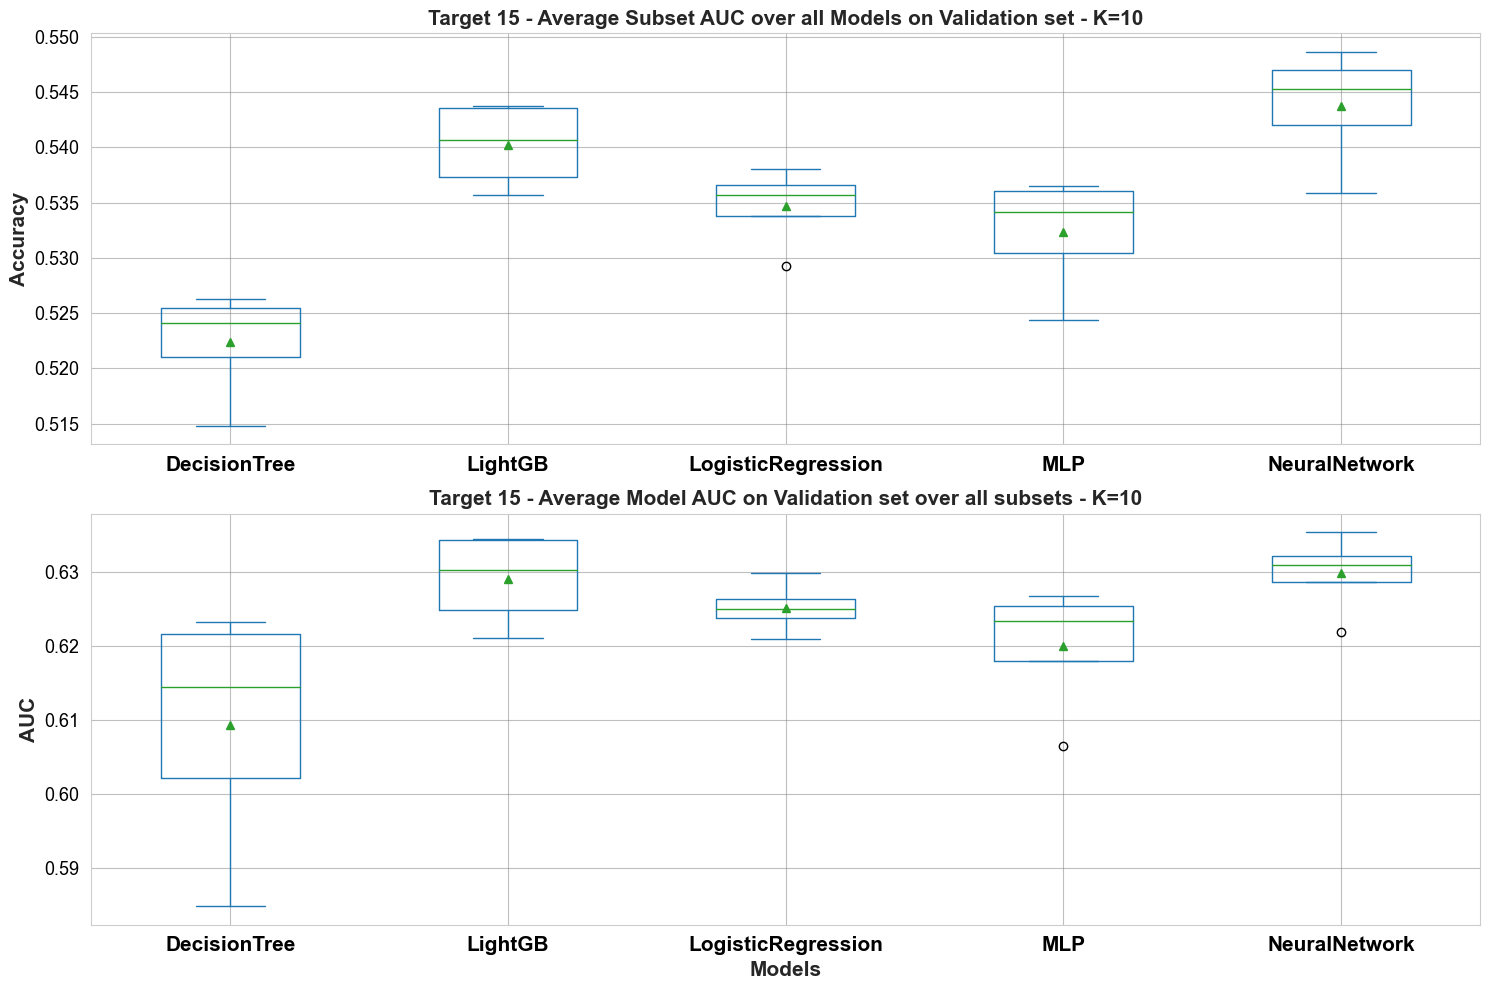

In [37]:
import matplotlib.pyplot as plt

# Assuming the dataframes and other variables are defined earlier in the code
#set figure and size
plt.figure(figsize=(15, 10))
#set 1st subplot
ax1 = plt.subplot(2, 1, 1)

a = target_0_validation.copy()
df_assess = a['accuracy_test']
# First subplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15, weight='bold')
ax1.set_xlabel('', size=15, weight='bold')
ax1.set_ylabel('Accuracy', size=15, weight='bold')

ax1.tick_params(axis='x', labelsize=15, labelrotation=0, which='both', width=1, direction='out', pad=5, colors='black', grid_color='grey', grid_alpha=0.5)
for label in ax1.get_xticklabels():
    label.set_weight("bold")

ax1.tick_params(axis='y', labelsize=13, labelrotation=0, which='both', width=1, direction='out', pad=5, colors='black', grid_color='grey', grid_alpha=0.5)

title = 'Target 15 - Average Model AUC on Validation set over all subsets - K=10'

# Second subplot
ax2 = plt.subplot(2, 1, 2) # Share x-axis ticks with ax1
a = target_15_validation.copy()

#filter dataframe to plot
df_assess = a['auc_test']
print('Precision')
display(df_assess.mean())
#plot boxplot
df_assess.plot(kind='box', showmeans=True, ax=ax2)

#set title and labels
ax2.set_xlabel('Models', size=15, weight='bold')
ax2.set_ylabel('AUC', size=15, weight='bold')
ax2.set_title(title, size=15, weight='bold')
ax2.tick_params(axis='x', labelsize=15, labelrotation=0, which='both', width=1, direction='out', pad=5, colors='black', grid_color='grey', grid_alpha=0.5)
for label in ax2.get_xticklabels():
    label.set_weight("bold")

ax2.tick_params(axis='y', labelsize=13, labelrotation=0, which='both', width=1, direction='out', pad=5, colors='black', grid_color='grey', grid_alpha=0.5)

# Display the plots
plt.tight_layout()
#set path to save plot
path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Results'
finalTitle = r'ModelsSubsetPerformance'
name_plot = f'{path}\\{finalTitle}.png'
plt.savefig(name_plot, dpi=600)
#show plot
plt.show()


#### Not in Bold

Accuracy


model
DecisionTree          0.522337
LightGB               0.540199
LogisticRegression    0.534673
MLP                   0.532309
NeuralNetwork         0.543775
dtype: float64

Precision


model
DecisionTree          0.609259
LightGB               0.629037
LogisticRegression    0.625223
MLP                   0.620006
NeuralNetwork         0.629841
dtype: float64

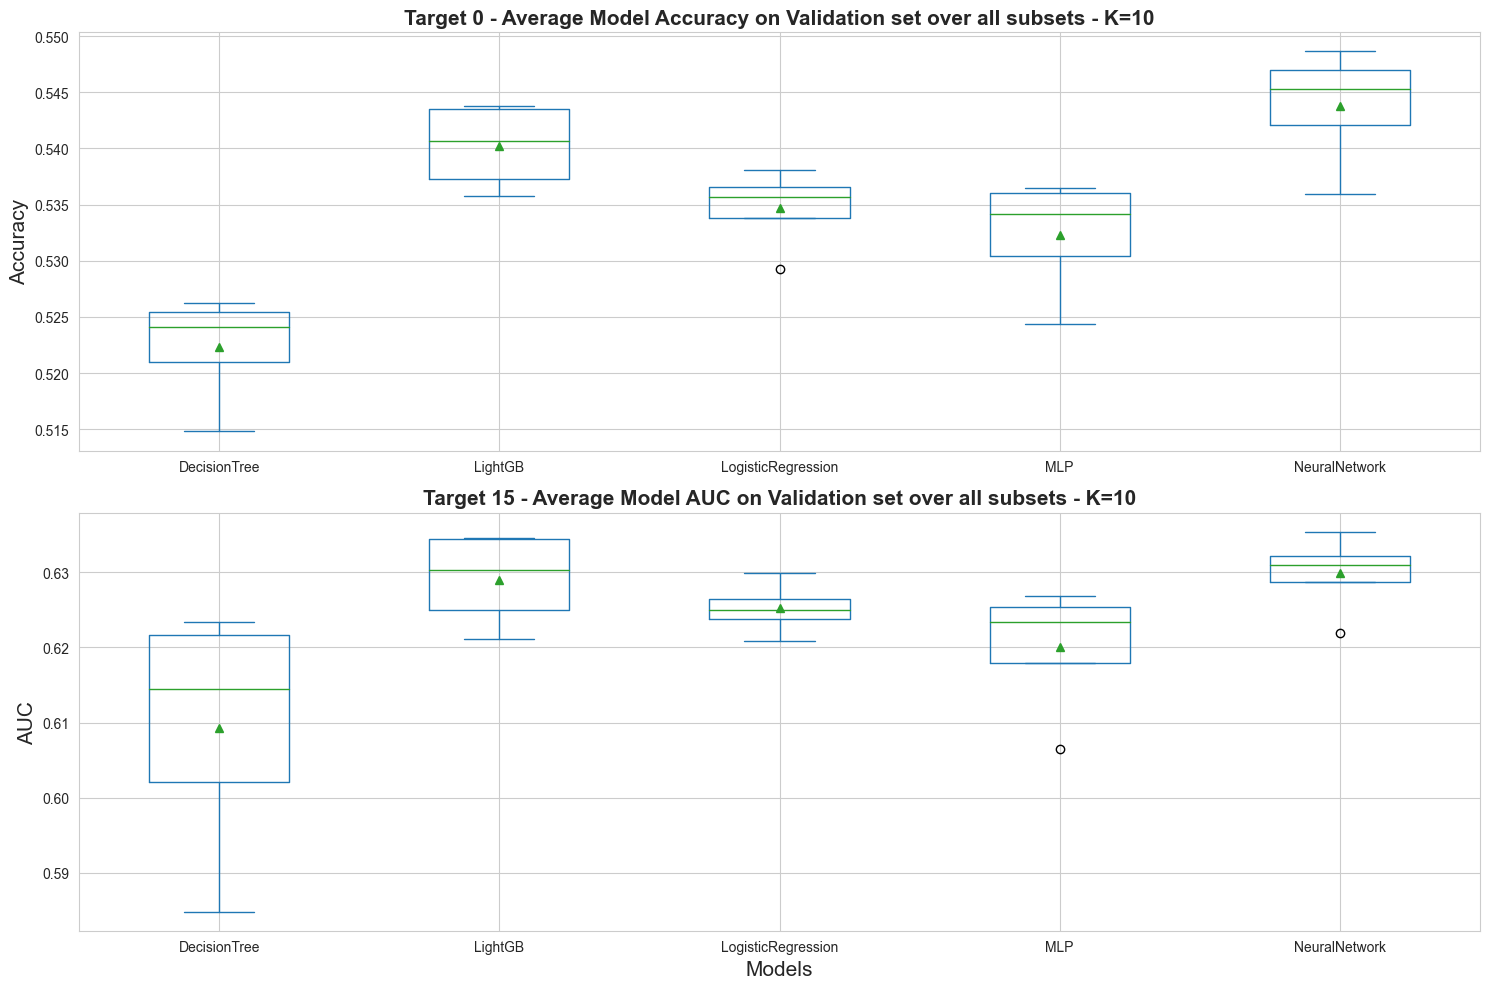

In [28]:
#set title
title = 'Target 0 - Average Model Accuracy on Validation set over all subsets - K=10'
#set copy of dataframe to plot
a = target_0_validation.copy()

#set figure and size
plt.figure(figsize=(15, 10))
#set 1st subplot
ax1 = plt.subplot(2, 1, 1)
#filter dataframe to plot
df_assess = a['accuracy_test']
print('Accuracy')
display(df_assess.mean())
#plot boxplot
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)

#set title and labels
ax1.set_title(title, size=15, weight='bold')
ax1.set_xlabel('', size=15)
ax1.set_ylabel('Accuracy', size=15)

title = 'Target 15 - Average Model AUC on Validation set over all subsets - K=10'
#set 2nd subplot
ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
a = target_15_validation.copy()

#filter dataframe to plot
df_assess = a['auc_test']
print('Precision')
display(df_assess.mean())
#plot boxplot
df_assess.plot(kind='box', showmeans=True,ax=ax2)
#set title and labels
ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('AUC', size=15)
ax2.set_title(title,size = 15, weight='bold')
plt.tight_layout()
#set path to save plot
path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Results'
finalTitle = r'ModelsSubsetPerformance'
name_plot = f'{path}\\{finalTitle}.png'
plt.savefig(name_plot, dpi=600)
#show plot
plt.show()

#### Portfolio Performance by Target 

In [84]:
def concatReturns (returns_Target_0,returns_Target15):
    
    returns_0 = returns_Target_0.copy()
    returns_15 = returns_Target15.copy()
    if 'Target' not in returns_0.columns:
        returns_0['Target'] = 'Target 0'
        
    if 'Target' not in returns_15.columns:
        returns_15['Target'] = 'Target 15'
        
    fullReturns = pd.concat([returns_0,returns_15],
                            axis=0)
    fullReturns.loc[fullReturns.index.get_level_values(0)=='Random','Target'] = 'Benchmark'
    fullReturns = fullReturns.stack('sample')
    fullReturns['Target'] = fullReturns['Target'].bfill()
    fullReturns = fullReturns.dropna()
    fullReturns = fullReturns.reset_index().set_index(['model','sample','Target'])
    return(fullReturns)

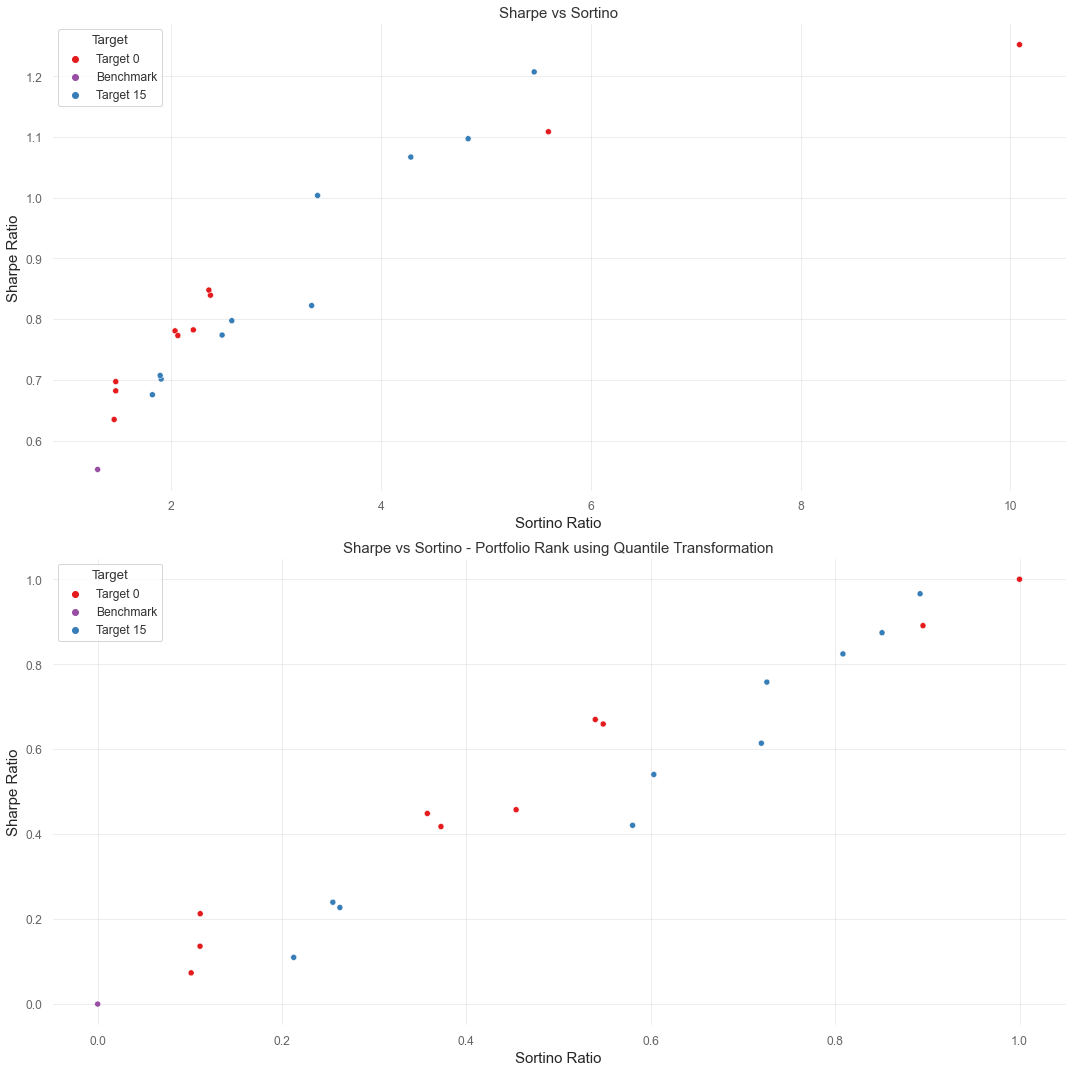

In [65]:
fullRatios = concatReturns(qsRatios_0, qsRatios_15)[['sharpe','sorttino']].iloc[:-1]
# fullRatios.loc[fullRatios.index.get_level_values(0)=='Random','Target'] = 'Benchmark'
fullRatiosRank  = fullRatios.rank(ascending = False)


fullRatiosRank_quantile = ft_extract.quantile_transform_df(fullRatios)


color_list = [palette[0],palette[3],palette[1]]


plt.figure(figsize = (15,15))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)



sns.scatterplot(data= fullRatios,
                y = 'sharpe',
                x = 'sorttino', 
                hue = 'Target',
                palette = color_list, ax=ax1 )


sns.scatterplot(data= fullRatiosRank_quantile,
                y = 'sharpe',
                x = 'sorttino', 
                hue = 'Target',
                palette = color_list, ax=ax2 )


ax1.set_title('Sharpe vs Sortino',size = 15)
ax2.set_title('Sharpe vs Sortino - Portfolio Rank using Quantile Transformation',size=15)

ax1.set_xlabel('Sortino Ratio', size = 15)
ax2.set_xlabel('Sortino Ratio', size = 15)

ax1.set_ylabel('Sharpe Ratio', size = 15)
ax2.set_ylabel('Sharpe Ratio', size = 15)

plt.tight_layout()

title = 'Portfolio Performance'
path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Assessment'
name_plot = f'{path}\\{title}.png'
# plt.savefig(name_plot, dpi=300)


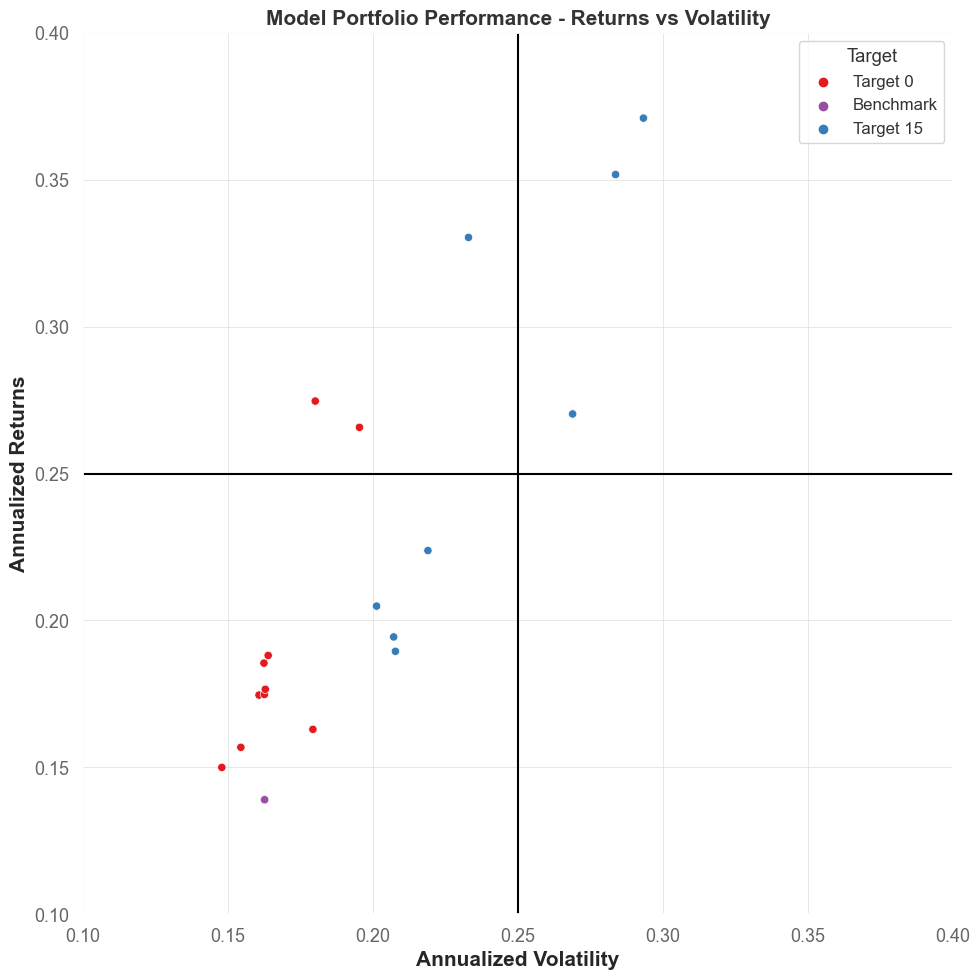

In [100]:
returns_15 = returns_15.loc[returns_15.index!='MLP']
returns_15 = returns_15.loc[returns_15.index!='Random']
fullReturns = concatReturns(returns_0, returns_15)
to_plot = fullReturns.iloc[:,:2]
plt.figure(figsize = (10,10))
sns.scatterplot(data= to_plot,
                y = 'annualizedReturns',
                x = 'annualizedVolatility', 
                hue = 'Target',palette = color_list )

title = 'Model Portfolio Performance - Returns vs Volatility'
plt.title(title,size = 15,weight = 'bold')
plt.xlabel('Annualized Volatility', size = 15, weight = 'bold')
plt.ylabel('Annualized Returns', size = 15,weight = 'bold')

plt.xticks(size =13)
plt.yticks(size =13)
plt.ylim(0.1,0.40)
plt.xlim(0.1,0.40)
# plt.axline([0.1,0.1], [0.4,0.40], color = 'green')

plt.axhline(0.25, color = 'black')
plt.axvline(0.25, color = 'black')
plt.tight_layout()
# title = 'Portfolio Performance'
path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Results'
name_plot = f'{path}\\{title}.png'
plt.savefig(name_plot, dpi=600)

In [41]:
to_merge = fundData.resample('Q').agg('last').pct_change().dropna().iloc[:-1]

bestModela_target0 = top50_returns[['LightGB_returns_Top50','LogisticRegression_returns_Top50','NeuralNetwork_returns_Top50']]
bestModela_target15 = top50_returns_15[['NeuralNetwork_returns_Top50','NeuralNetwork_PCA_returns_Top50','LightGB_returns_Top50','Random_returns']]

returns_compare = pd.concat([bestModela_target0,bestModela_target15],
                           axis=1)
for col in to_merge.columns:
    returns_compare[col] = to_merge[col].values
    
    
cumReturns = returns_compare.cumsum()

cumReturns.iloc[-1].sort_values(ascending=False)

NeuralNetwork_returns_Top50         1.854832
LightGB_returns_Top50               1.759150
NeuralNetwork_PCA_returns_Top50     1.651887
LightGB_returns_Top50               1.373439
VGT                                 1.053925
QQQ                                 0.897188
LogisticRegression_returns_Top50    0.784106
NeuralNetwork_returns_Top50         0.749954
Random_returns                      0.694922
VOO                                 0.639101
IVV                                 0.638494
SPY                                 0.637528
BRK-A                               0.571078
Name: (2023.0, 1.0), dtype: float64

#### Average Alpha per Target

In [143]:
import HypothesisTesting as statsTest
model_name = 'LightGB_Raw'
prob_name = model_name + '_proba'
pred_name = model_name + '_prediction'

query_ = (assess_test.year==2018) & (assess_test.quarter==2)
pos_df_0 = assess_test.loc[(assess_test[pred_name]==True) ].sort_values(ascending=False, by=prob_name)['futAlpha']

model_name = 'NeuralNetwork'
prob_name = model_name + '_proba'
pred_name = model_name + '_prediction'
pos_df_15 = assess_test_15.loc[(assess_test_15[pred_name]==True) ].sort_values(ascending=False, by=prob_name)['futAlpha']


pct = 0.2
n = 500

pos_bootstrap_0, pos_df_stats_0 = statsTest.BootstrapSampling(pos_df_0, pct, n)
pos_df_stats_0.rename(columns ={'bootStrap_mean':'Porfolios_returns'} , inplace = True)

pos_bootstrap_15, pos_df_stats_15 = statsTest.BootstrapSampling(pos_df_15,pct, n)
pos_df_stats_15.rename(columns ={'bootStrap_mean':'Porfolios_returns'} , inplace = True)

neg_df= assess_test.loc[:]['futAlpha']
neg_bootstrap,neg_df_stats = statsTest.BootstrapSampling(neg_df, pct, n)
neg_df_stats.rename(columns ={'bootStrap_mean':'random_returns'} , inplace = True)

Confidence Intervals of the mean:
90% : [0.00656723 0.01556911]
95% : [0.00518028 0.0167846 ]
99% : [0.00254016 0.0185215 ]
 
Confidence Intervals of the standard deviation:
90% : [0.1664633  0.18142624]
95% : [0.16443765 0.18344343]
99% : [0.16137825 0.18745661]
Confidence Intervals of the mean:
90% : [0.0027861  0.01945426]
95% : [0.00115916 0.02203572]
99% : [-0.00294053  0.02507153]
 
Confidence Intervals of the standard deviation:
90% : [0.23605347 0.25504393]
95% : [0.23317277 0.25730326]
99% : [0.22854342 0.26254219]
Confidence Intervals of the mean:
90% : [-0.00012696  0.00718549]
95% : [-0.0013162   0.00813168]
99% : [-0.00267213  0.0097076 ]
 
Confidence Intervals of the standard deviation:
90% : [0.17539934 0.18626021]
95% : [0.17394576 0.18734642]
99% : [0.1712861  0.19107045]


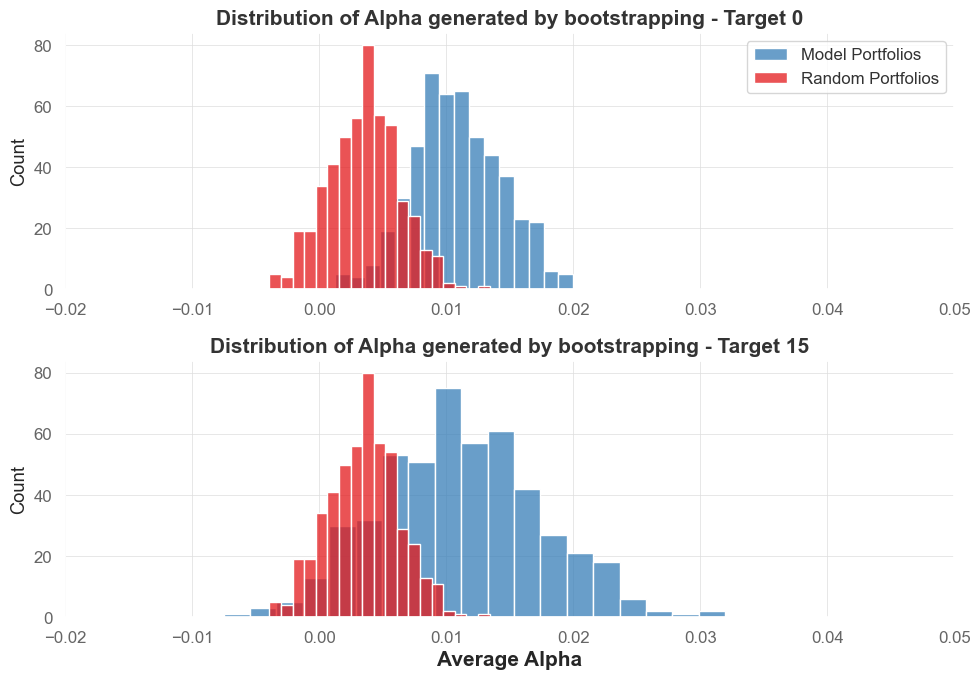

In [148]:
plt.figure(figsize=(10, 7))
#set 1st subplot
ax1 = plt.subplot(2, 1, 1)

title = 'Distribution of Alpha generated by bootstrapping - Target 0'
sns.histplot(x= 'Porfolios_returns', data = pos_df_stats_0,
            color = palette[1], label = 'Model Portfolios',legend=True, ax = ax1)
sns.histplot(x= 'random_returns', data = neg_df_stats, color = palette[0], label = 'Random Portfolios', legend=True, ax = ax1)
ax1.set_title(title,size = 15, weight = 'bold')
plt.legend()
ax1.set_xlabel('')
ax1.set_xlim(-0.02,0.05)


ax2 = plt.subplot(2, 1, 2)
title = 'Distribution of Alpha generated by bootstrapping - Target 15'
sns.histplot(x= 'Porfolios_returns', data = pos_df_stats_15, color = palette[1], label = 'Model Portfolios',legend=True,ax = ax2)
sns.histplot(x= 'random_returns', data = neg_df_stats, color = palette[0], label = 'Random Portfolios', legend=True,ax = ax2)
ax2.set_title( title,size = 15, weight = 'bold')
ax2.set_xlim(-0.02,0.05)
# plt.legend()
ax2.set_xlabel('Average Alpha', size = 15, weight = 'bold')
plt.tight_layout()

title = r'Distribution of Alpha generated by bootstrapping'
path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Results'
name_plot = f'{path}\\{title}.png'
plt.savefig(name_plot, dpi=600)